In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import linregress
from statsmodels.tsa.arima.model import ARIMA
from pyts.decomposition import SingularSpectrumAnalysis
from pmdarima.arima import auto_arima
import warnings
import itertools
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram, find_peaks
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox, normaltest
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import pywt
from sklearn.decomposition import PCA
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.utils.extmath import randomized_svd
from PyEMD import EMD
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis
from pykalman import KalmanFilter
import torch
import torch.nn as nn
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from astropy.timeseries import LombScargle
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from scipy.stats import ttest_ind
import datetime
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.signal import correlate
from scipy.fft import fft, fftfreq
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from collections import Counter
from sklearn.cluster import DBSCAN
import requests
from io import StringIO
from scipy.stats import spearmanr
from sklearn.metrics import mutual_info_score
from statsmodels.tsa.stattools import grangercausalitytests
from pyinform.transferentropy import transfer_entropy
from tigramite.data_processing import DataFrame as TDF
from tigramite.pcmci import PCMCI
import pyinform
from sklearn.ensemble import IsolationForest
import yfinance as yf
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn as nn
from pytrends.request import TrendReq
from fredapi import Fred
from dotenv import load_dotenv
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.utils import resample
from scipy.signal import hilbert
from dtaidistance import dtw
from scipy.signal import coherence, csd
from pycoingecko import CoinGeckoAPI
import pandas as pd
import numpy as np
from datetime import date, timedelta
from scipy.stats import pearsonr
import joblib
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pytz
from tqdm import tqdm
from scipy.stats import zscore
from scipy.ndimage import median_filter
from sklearn.metrics import precision_score, recall_score, f1_score
import ta
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import VotingClassifier
from collections import defaultdict
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting  # Нужно для активации
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import pandas_datareader.data as web
from tiingo import TiingoClient
from pykalman import KalmanFilter
# from pytorch_forecasting import TimeSeriesDataSet
# from pytorch_forecasting.data import NaNLabelEncoder
# from pytorch_forecasting import TemporalFusionTransformer
# from pytorch_lightning import Trainer
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
# from pytorch_forecasting.metrics.base_metrics import Metric
# from lightning.pytorch import Trainer, LightningModule
import ccxt
import torch.nn.functional as F
from stable_baselines3 import PPO
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from collections import deque
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import MlpExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import BaseCallback
from collections import deque
import ast

# Подавляем только FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
''' FUNCTIONS '''

# Конввертируем время в привычный вариант
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

def plot_strategy_vs_buy_hold(df_signals, threshold=0.6, resample='1H', show_signals=True, max_return=10.0):
    """
    Визуализация стратегии и сравнение с Buy & Hold.

    Parameters:
    - df_signals: DataFrame с колонками ['strategy_return', 'future_return', 'signal']
    - threshold: значение, использованное при генерации сигналов
    - resample: частота агрегации ('1H', '1D', 'W', и т.д.)
    - show_signals: если True — отмечает сделки на графике
    - max_return: максимальное значение cumulative return, выше которого обрезаются выбросы
    """
    df_plot = df_signals.copy()

    # Убедимся, что индекс — datetime
    df_plot.index = pd.to_datetime(df_plot.index)
    df_plot = df_plot.sort_index()

    # Пересчитаем кумулятивные доходности
    df_plot['cumulative_return'] = (1 + df_plot['strategy_return']).cumprod()
    df_plot['buy_and_hold'] = (1 + df_plot['future_return']).cumprod()

    # Удалим выбросы
    df_plot = df_plot[(df_plot['cumulative_return'] < max_return) & (df_plot['buy_and_hold'] < max_return)]

    # Агрегация
    df_plot = df_plot.resample(resample).last()

    # График
    plt.figure(figsize=(12, 6))
    plt.plot(df_plot.index, df_plot['cumulative_return'], label='Strategy')
    plt.plot(df_plot.index, df_plot['buy_and_hold'], label='Buy & Hold', linestyle='--')
    
    # Точки входа
    if show_signals and 'signal' in df_plot.columns:
        entry_points = df_plot[df_plot['signal'] == 1]
        plt.scatter(entry_points.index, entry_points['cumulative_return'], color='green', marker='^', label='Entries', zorder=5)

    plt.title(f'Strategy vs Buy & Hold (threshold={threshold}, resample={resample})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Strategy vs Buy & Hold", dpi=300)
    plt.show()

def bar_plot(x, y,palette_len,title='Missing Values (%)', xlim = None, ylim = None, 
             xticklabels = None, yticklabels = None,xlabel = None, ylabel = None, 
             figsize = (10,4),axis_grid = 'y'):
        
    cmap = sns.color_palette("plasma")
    fig, ax = plt.subplots(figsize = figsize)
    plt.title(title,size = 15, fontweight = 'bold')

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')
    
    ax.spines['top'].set_visible(True);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)

    sns.barplot(x = x, y = y, edgecolor = 'black', ax = ax,
                palette = cmap)
    ax.set_xlim(xlim);ax.set_ylim(ylim)    
    ax.set_xticklabels(xticklabels);ax.set_yticklabels(yticklabels)
    plt.xlabel(xlabel);plt.ylabel(ylabel)
    ax.grid(axis = axis_grid,ls='--',alpha = 0.9)
    plt.show()

def compute_indicators_v6(df, trend_emd=None, future_horizon=5, threshold=0.02, kalman_smooth=False):

    if kalman_smooth:

        kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
        df = df.copy()
        
        for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
            smoothed, _ = kf.smooth(df[col].values)
            df[col] = smoothed.flatten()
        
    price_orig = df['Close']

    # Если передан тренд из EMD — использовать его как очищенную цену для индикаторов (для снижения шума)
    price = trend_emd if trend_emd is not None else price_orig

    o, h, l, c, v = df['Open'], df['High'], df['Low'], df['Close'], df['Volume']

    # --- Скользящие средние ---
    df['sma_1d'] = price
    df['sma_1w'] = price.rolling(7).mean()
    df['sma_signal'] = (df['sma_1d'] > df['sma_1w']).astype(int)

    ema12 = price.ewm(span=12, adjust=False).mean()
    ema26 = price.ewm(span=26, adjust=False).mean()
    df['ema_crossover'] = (ema12 > ema26).astype(int)

    # --- RSI ---
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(14).mean() / (loss.rolling(14).mean() + 1e-8)
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_signal'] = (df['rsi'] < 30).astype(int)

    # --- MACD ---
    macd = ema12 - ema26
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    df['macd'] = macd
    df['macd_signal'] = macd_signal
    df['macd_signal_bin'] = (macd > macd_signal).astype(int)

    # --- Volatility ---
    window_size = 7
    df['volatility_1d'] = price.rolling(window=window_size).std()
    median_vol = df['volatility_1d'].median()
    df['volatility_signal'] = (df['volatility_1d'] > median_vol).astype(int)
    vol_roll = df['volatility_1d'].rolling(14)
    df['volatility_z'] = (df['volatility_1d'] - vol_roll.mean()) / (vol_roll.std() + 1e-8)

    # --- Bollinger Bands ---
    bb = ta.volatility.BollingerBands(close=price, window=20, window_dev=2)
    df['bb_hband_indicator'] = bb.bollinger_hband_indicator()
    df['bb_lband_indicator'] = bb.bollinger_lband_indicator()

    # --- ATR ---
    df['atr'] = ta.volatility.AverageTrueRange(high=h, low=l, close=c, window=14).average_true_range()

    # --- On Balance Volume ---
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=c, volume=v).on_balance_volume()

    # --- Stochastic RSI ---
    df['stoch_rsi'] = ta.momentum.StochasticOscillator(high=h, low=l, close=c, window=14).stoch()

    # --- Новые индикаторы ---

    # ADX - сила тренда
    df['adx'] = ta.trend.ADXIndicator(high=h, low=l, close=c, window=14).adx()

    # CCI - перепроданность/перекупленность
    df['cci'] = ta.trend.CCIIndicator(high=h, low=l, close=c, window=20).cci()

    # Williams %R
    df['williams_r'] = ta.momentum.WilliamsRIndicator(high=h, low=l, close=c, lbp=14).williams_r()

    # Parabolic SAR
    df['psar'] = ta.trend.PSARIndicator(high=h, low=l, close=c, step=0.02, max_step=0.2).psar()

    # Momentum
    df['momentum'] = c - c.shift(10)

    # Chaikin Money Flow
    df['cmf'] = ta.volume.ChaikinMoneyFlowIndicator(high=h, low=l, close=c, volume=v, window=20).chaikin_money_flow()

    # --- Свечные паттерны ---
    df['bull_candle'] = (c > o).astype(int)
    df['bear_candle'] = (c < o).astype(int)
    hl_range = h - l + 1e-8
    df['hammer'] = ((h - l > 3 * abs(o - c)) &
                    ((c - l) / hl_range > 0.6) &
                    ((o - l) / hl_range > 0.6)).astype(int)
    df['doji'] = (abs(c - o) <= 0.05 * hl_range).astype(int)
    df['shooting_star'] = ((h - l > 3 * abs(o - c)) &
                           ((h - c) / hl_range > 0.6) &
                           ((h - o) / hl_range > 0.6)).astype(int)

    prev_c, prev_o = c.shift(1), o.shift(1)
    df['bullish_engulfing'] = ((prev_c < prev_o) & (c > o) & (c > prev_o) & (o < prev_c)).astype(int)
    df['bearish_engulfing'] = ((prev_c > prev_o) & (c < o) & (c < prev_o) & (o > prev_c)).astype(int)
    df['morning_star'] = ((df['bear_candle'].shift(2) == 1) &
                          (df['doji'].shift(1) == 1) &
                          (df['bull_candle'] == 1)).astype(int)
    df['evening_star'] = ((df['bull_candle'].shift(2) == 1) &
                          (df['doji'].shift(1) == 1) &
                          (df['bear_candle'] == 1)).astype(int)

    # --- Корреляции ---
    df['corr_price_volume_7'] = c.rolling(7).corr(v)
    df['corr_obv_price_7'] = df['obv'].rolling(7).corr(c)

    # --- Volume spike ---
    df['volume_spike'] = (v > 1.5 * v.rolling(14).mean()).astype(int)

    # --- Лаги ---
    lag_cols = ['Close', 'Volume', 'rsi', 'macd', 'macd_signal', 'obv', 'stoch_rsi', 'adx', 'cci', 'williams_r', 'momentum', 'cmf']
    for col in lag_cols:
        for lag in range(1, 4):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)

    # --- Целевая переменная ---
    df['future_return'] = df['Close'].shift(-future_horizon) / df['Close'] - 1
    df['target'] = (df['future_return'] > threshold).astype(int)

    # --- Свечная кластеризация ---
    candle_features = pd.DataFrame({
        'body': abs(c - o),
        'upper_shadow': h - np.maximum(c, o),
        'lower_shadow': np.maximum(0, np.minimum(c, o) - l)
    }).replace([np.inf, -np.inf], 0).fillna(0)
    candle_scaled = StandardScaler().fit_transform(candle_features)
    kmeans = KMeans(n_clusters=6, random_state=42).fit(candle_scaled)
    df['candle_cluster'] = kmeans.labels_

    # --- Комбинированный сигнал ---
    signals = ['sma_signal', 'ema_crossover', 'rsi_signal', 'macd_signal_bin', 'volatility_signal']
    df['combined_signal'] = df[signals].sum(axis=1)

    # --- Заполнение пропусков ---
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)            # out shape: (batch, seq_len, hidden_dim)
        out = out[:, -1, :]              # взять последний временной шаг (batch, hidden_dim)
        out = self.dropout(out)
        out = self.fc(out)               # (batch, 1)
        return out.view(-1)              # привести к (batch,), чтобы loss корректно считывал


# --- Кастомный Dataset ---
class SequenceDataset(Dataset):
    def __init__(self, X, y, timestamps):
        self.X = X
        self.y = y
        # Преобразуем все timestamps в строку
        self.timestamps = pd.to_datetime(timestamps).astype(str).tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.timestamps[idx]

# --- Создание последовательностей ---
def create_sequences(X, y, timesteps, horizon, timestamps):
    Xs, ys, ts = [], [], []

    for i in range(len(X) - timesteps - horizon + 1):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps + horizon - 1])  # целевое значение через horizon
        ts.append(timestamps[i+timesteps + horizon - 1])  # timestamp для точки предсказания

    return np.array(Xs), np.array(ys), np.array(ts)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for i, batch in enumerate(loader):
        X_batch, y_batch, *_ = batch
        X_batch = X_batch.float().to(device)  # 👈 float32
        y_batch = y_batch.float().to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(loader.dataset)

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    losses, all_preds, all_targets, all_timestamps = [], [], [], []

    with torch.no_grad():
        for batch in dataloader:
            X_batch, y_batch, ts_batch = batch
            X_batch, y_batch = X_batch.float().to(device), y_batch.to(device)

            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            losses.append(loss.item())

            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
            all_timestamps.extend(ts_batch)  # теперь это list[str]

    # Преобразуем строки обратно в Timestamp
    all_timestamps = pd.to_datetime(all_timestamps)

    return np.mean(losses), np.array(all_preds), np.array(all_targets), all_timestamps


# class CustomBinaryCrossEntropy(Metric):
#     def __init__(self):
#         super().__init__()
#         self.loss_fn = torch.nn.BCEWithLogitsLoss(reduction="sum")
#         self.add_state("loss_sum", default=torch.tensor(0.0), dist_reduce_fx="sum")
#         self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

#     def update(self, y_pred, target):
#         if isinstance(y_pred, (tuple, list)):
#             y_pred = y_pred[0]
#         if isinstance(target, (tuple, list)):
#             target = target[0]
    
#         # Перемещаем target на устройство y_pred
#         target = target.to(y_pred.device)
    
#         # Приведение размерностей
#         if y_pred.ndim == 3 and y_pred.shape[2] == 1 and target.ndim == 2:
#             y_pred = y_pred.squeeze(-1)
#         elif y_pred.ndim == 3 and target.ndim == 2:
#             target = target.unsqueeze(1)  # [B, 1] -> [B, 1, 1]
    
#         # Приведение типов
#         y_pred = y_pred.float()
#         target = target.float()
    
#         loss = self.loss_fn(y_pred, target)
#         self.loss_sum += loss
#         self.total += target.numel()

#     def compute(self):
#         return self.loss_sum / self.total


# Загружаем датафрейм

In [16]:
path ='btc_15m_data_2018_to_2025.csv'

In [20]:
btc_df = pd.read_csv('btc_15m_data_2018_to_2025.csv',  index_col='Open time')

In [21]:
btc_df

,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
Open time,,,,,,,,,,,
2018-01-01 00:00:00,"13,715.65","13,715.65","13,400.01","13,556.15",123.62,2018-01-01 00:14:59.999,"1,675,544.89",1572,63.23,"857,610.83",0
2018-01-01 00:15:00,"13,533.75","13,550.87","13,402.00","13,521.12",98.14,2018-01-01 00:29:59.999,"1,321,756.85",1461,47.69,"642,281.17",0
2018-01-01 00:30:00,"13,500.00","13,545.37","13,450.00","13,470.41",79.90,2018-01-01 00:44:59.999,"1,078,825.29",1000,43.71,"590,034.71",0
2018-01-01 00:45:00,"13,494.65","13,690.87","13,450.00","13,529.01",141.70,2018-01-01 00:59:59.999,"1,917,782.81",1195,73.90,"1,000,614.39",0
2018-01-01 01:00:00,"13,528.99","13,571.74","13,402.28","13,445.63",72.54,2018-01-01 01:14:59.999,"977,819.79",898,34.26,"461,836.85",0
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24 23:00:00,"106,025.39","106,028.00","105,828.57","105,864.66",62.20,2025-06-24 23:14:59.999,"6,587,454.33",17053,30.29,"3,208,619.82",0
2025-06-24 23:15:00,"105,864.67","105,864.67","105,774.90","105,837.89",54.34,2025-06-24 23:29:59.999,"5,749,910.45",12214,14.93,"1,579,963.57",0
2025-06-24 23:30:00,"105,837.90","105,935.10","105,804.06","105,907.13",53.59,2025-06-24 23:44:59.999,"5,674,537.82",12562,19.19,"2,030,985.60",0


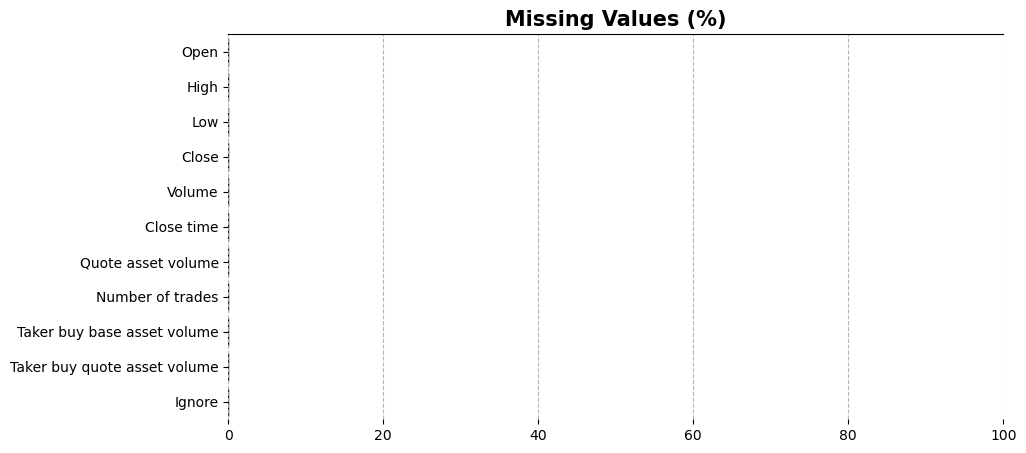

In [22]:
# Посмотрим что у нас с пропусками
NaN_values = (btc_df.isnull().sum()/len(btc_df)*100).sort_values(ascending = False)

# Plot missing data
bar_plot(x = NaN_values,y = NaN_values.index,palette_len = NaN_values.index, 
         xlim = (0,100),xticklabels = range(0,101,20),yticklabels = NaN_values.index,
         figsize = (10,5), axis_grid = 'x')

In [12]:
NaN_values

Open     0.00
High     0.00
Low      0.00
Close    0.00
Volume   0.00
dtype: float64

# 1.Готовим датайфрейм 

## 1.1 Подрезка с даты халвинга

In [23]:
btc_df_after_halving = btc_df[btc_df.index >= '2020-05-11']

In [29]:
btc_df_after_halving.index.name = 'Timestamp'

In [31]:
btc_df_after_halving = btc_df_after_halving.drop(columns=['Ignore','Close time'])

In [32]:
btc_df_after_halving

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Timestamp,,,,,,,,,
2020-05-11 00:00:00,"8,722.77","8,800.00","8,721.00","8,745.19","1,201.41","10,528,954.94",8989,636.99,"5,583,818.86"
2020-05-11 00:15:00,"8,745.93","8,796.24","8,745.93","8,778.35",782.20,"6,864,492.57",8713,357.29,"3,135,830.40"
2020-05-11 00:30:00,"8,778.85","8,805.14","8,749.94","8,758.57",745.52,"6,544,348.12",9044,329.34,"2,891,749.14"
2020-05-11 00:45:00,"8,758.45","8,770.33","8,696.00","8,770.16","1,083.71","9,463,730.78",8832,503.38,"4,396,292.27"
2020-05-11 01:00:00,"8,770.15","8,775.00","8,729.46","8,746.37",594.28,"5,199,193.57",6208,236.29,"2,066,803.28"
...,...,...,...,...,...,...,...,...,...
2025-06-24 23:00:00,"106,025.39","106,028.00","105,828.57","105,864.66",62.20,"6,587,454.33",17053,30.29,"3,208,619.82"
2025-06-24 23:15:00,"105,864.67","105,864.67","105,774.90","105,837.89",54.34,"5,749,910.45",12214,14.93,"1,579,963.57"
2025-06-24 23:30:00,"105,837.90","105,935.10","105,804.06","105,907.13",53.59,"5,674,537.82",12562,19.19,"2,030,985.60"


## 1.2 Применение функции генерации техничксикх индексов

In [33]:
btc_with_ta = compute_indicators_v6(btc_df_after_halving, kalman_smooth=True)

In [34]:
btc_with_ta

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,sma_1d,...,momentum_lag1,momentum_lag2,momentum_lag3,cmf_lag1,cmf_lag2,cmf_lag3,future_return,target,candle_cluster,combined_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-11 00:00:00,"5,398.69","5,437.34","5,394.51","5,410.82",645.73,"10,528,954.94",8989,636.99,"5,583,818.86","5,410.82",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.61,1,0,0
2020-05-11 00:15:00,"7,473.29","7,512.02","7,462.54","7,487.28",735.77,"6,864,492.57",8713,357.29,"3,135,830.40","7,487.28",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.16,1,0,2
2020-05-11 00:30:00,"8,275.25","8,302.48","8,247.17","8,272.67",779.39,"6,544,348.12",9044,329.34,"2,891,749.14","8,272.67",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.05,1,0,2
2020-05-11 00:45:00,"8,573.62","8,590.27","8,529.02","8,572.16",856.87,"9,463,730.78",8832,503.38,"4,396,292.27","8,572.16",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.02,0,0,2
2020-05-11 01:00:00,"8,687.17","8,698.02","8,643.90","8,673.65",707.50,"5,199,193.57",6208,236.29,"2,066,803.28","8,673.65",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.01,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24 23:00:00,"105,955.85","105,994.48","105,831.36","105,910.14",58.22,"6,587,454.33",17053,30.29,"3,208,619.82","105,910.14",...,195.66,333.04,345.70,0.03,0.02,0.04,0.00,0,4,1
2025-06-24 23:15:00,"105,904.51","105,954.72","105,813.55","105,907.77",61.17,"5,749,910.45",12214,14.93,"1,579,963.57","105,907.77",...,42.42,195.66,333.04,0.05,0.03,0.02,0.00,0,4,1
2025-06-24 23:30:00,"105,893.03","106,005.01","105,834.40","105,975.29",70.97,"5,674,537.82",12562,19.19,"2,030,985.60","105,975.29",...,-47.46,42.42,195.66,0.07,0.05,0.03,0.00,0,4,2


In [35]:
# Сохраняем
# btc_with_ta.to_csv('btc_with_ta.csv')
# btc_df_after_halving.to_csv('btc_df_after_halving.csv')


In [4]:
btc_with_ta = pd.read_csv('btc_with_ta.csv',  index_col='Timestamp')
btc_df_after_halving = pd.read_csv('btc_df_after_halving.csv',  index_col='Timestamp')

# 2. Присоединение криптоиндексов BITW, CCI30

# 3. Присоединение биржевого индекса QQQ (nasdaq) -нужна интерполяция на выходных

# 4. Присоединение индекса голода/жадности (факультативно)

# 5.Обучение модели (грузим один из набьоров данных)

## 5.1 На данных после чистки отшумов

In [36]:
btc_with_ta

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,sma_1d,...,momentum_lag1,momentum_lag2,momentum_lag3,cmf_lag1,cmf_lag2,cmf_lag3,future_return,target,candle_cluster,combined_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-11 00:00:00,"5,398.69","5,437.34","5,394.51","5,410.82",645.73,"10,528,954.94",8989,636.99,"5,583,818.86","5,410.82",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.61,1,0,0
2020-05-11 00:15:00,"7,473.29","7,512.02","7,462.54","7,487.28",735.77,"6,864,492.57",8713,357.29,"3,135,830.40","7,487.28",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.16,1,0,2
2020-05-11 00:30:00,"8,275.25","8,302.48","8,247.17","8,272.67",779.39,"6,544,348.12",9044,329.34,"2,891,749.14","8,272.67",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.05,1,0,2
2020-05-11 00:45:00,"8,573.62","8,590.27","8,529.02","8,572.16",856.87,"9,463,730.78",8832,503.38,"4,396,292.27","8,572.16",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.02,0,0,2
2020-05-11 01:00:00,"8,687.17","8,698.02","8,643.90","8,673.65",707.50,"5,199,193.57",6208,236.29,"2,066,803.28","8,673.65",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.01,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24 23:00:00,"105,955.85","105,994.48","105,831.36","105,910.14",58.22,"6,587,454.33",17053,30.29,"3,208,619.82","105,910.14",...,195.66,333.04,345.70,0.03,0.02,0.04,0.00,0,4,1
2025-06-24 23:15:00,"105,904.51","105,954.72","105,813.55","105,907.77",61.17,"5,749,910.45",12214,14.93,"1,579,963.57","105,907.77",...,42.42,195.66,333.04,0.05,0.03,0.02,0.00,0,4,1
2025-06-24 23:30:00,"105,893.03","106,005.01","105,834.40","105,975.29",70.97,"5,674,537.82",12562,19.19,"2,030,985.60","105,975.29",...,-47.46,42.42,195.66,0.07,0.05,0.03,0.00,0,4,2


In [4]:
# Удаляем строки с NaN или бесконечностями
df_clean_with_kal = btc_with_ta.drop(columns=['future_return','High', 'Close', 'Low', 'Open']).copy()
df_clean_with_kal = df_clean_with_kal.replace([np.inf, -np.inf], np.nan).dropna()

# Преобразуем целевую переменную
y = df_clean_with_kal['target'].values.astype(np.float32)
X = df_clean_with_kal.drop(columns=['target']).values

# Масштабируем
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
joblib.dump(scaler, 'scaler.save')

['scaler.save']

In [5]:
# Создаем последовательности
TIMESTEPS = 10
X_seq, y_seq, ts_seq = create_sequences(X_scaled, y, TIMESTEPS, horizon=1008, timestamps=df_clean_with_kal.index)

In [6]:
# --- Разделение на train/val/test ---
dataset = SequenceDataset(X_seq, y_seq.astype(np.float32), ts_seq)
train_size = int(len(dataset)*0.6)
val_size = int(len(dataset)*0.2)
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [7]:
# === Обучение ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model10min_with_kal = LSTMClassifier(input_dim=X_seq.shape[2], hidden_dim=64, num_layers=2, dropout=0.3).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model10min_with_kal.parameters(), lr=1e-3)

In [8]:
# --- Тренировка с early stopping ---
EPOCHS = 100
best_val_loss = np.inf
patience = 15
counter = 0

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model10min_with_kal, train_loader, criterion, optimizer, device)
    val_loss, test_preds, test_targets, timestamps = eval_epoch(model10min_with_kal, val_loader, criterion, device)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model10min_with_kal.state_dict(), "model10min_with_kal.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss=0.0303, Val Loss=0.0276
Epoch 2: Train Loss=0.0269, Val Loss=0.0274
Epoch 3: Train Loss=0.0259, Val Loss=0.0265
Epoch 4: Train Loss=0.0250, Val Loss=0.0260
Epoch 5: Train Loss=0.0240, Val Loss=0.0249
Epoch 6: Train Loss=0.0231, Val Loss=0.0243
Epoch 7: Train Loss=0.0217, Val Loss=0.0252
Epoch 8: Train Loss=0.0206, Val Loss=0.0240
Epoch 9: Train Loss=0.0197, Val Loss=0.0226
Epoch 10: Train Loss=0.0180, Val Loss=0.0218
Epoch 11: Train Loss=0.0173, Val Loss=0.0241
Epoch 12: Train Loss=0.0165, Val Loss=0.0217
Epoch 13: Train Loss=0.0155, Val Loss=0.0232
Epoch 14: Train Loss=0.0152, Val Loss=0.0209
Epoch 15: Train Loss=0.0143, Val Loss=0.0223
Epoch 16: Train Loss=0.0139, Val Loss=0.0212
Epoch 17: Train Loss=0.0131, Val Loss=0.0198
Epoch 18: Train Loss=0.0128, Val Loss=0.0202
Epoch 19: Train Loss=0.0122, Val Loss=0.0200
Epoch 20: Train Loss=0.0119, Val Loss=0.0197
Epoch 21: Train Loss=0.0112, Val Loss=0.0213
Epoch 22: Train Loss=0.0107, Val Loss=0.0227
Epoch 23: Train Los

In [9]:
# Загрузка лучшей модели
model10min_with_kal.load_state_dict(torch.load("model10min_with_kal.pth"))
model10min_with_kal.eval()

# Предсказания на тесте
test_loss, test_preds, test_targets, timestamps = eval_epoch(model10min_with_kal, test_loader, criterion, device)

# Получение вероятностей (sigmoid)
probas = torch.sigmoid(torch.tensor(test_preds)).numpy()

# Бинарные метки по порогу 0.5
pred_labels = (probas > 0.5).astype(int)

Accuracy: 0.9966
F1-score: 0.5536
ROC AUC: 0.9263


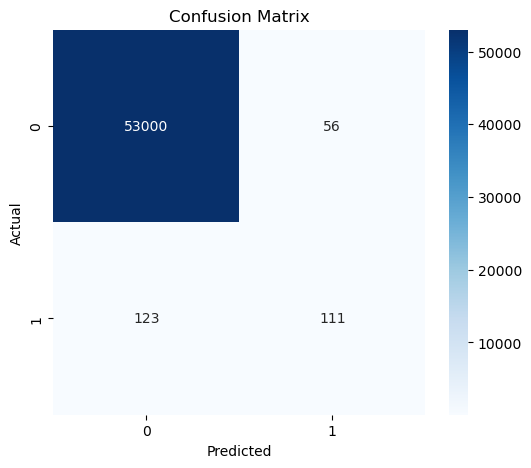

In [10]:
accuracy = accuracy_score(test_targets, pred_labels)
f1 = f1_score(test_targets, pred_labels)
roc_auc = roc_auc_score(test_targets, probas)
cm = confusion_matrix(test_targets, pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Визуализация матрицы ошибок
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# --- Настройка ---
threshold = 0.6  # Порог вероятности для входа в сделку

# Проверяем длины
assert len(probas) == len(timestamps)

# Приводим индекс btc_with_ta к datetime с таймзоной UTC
btc_with_ta.index = pd.to_datetime(btc_with_ta.index, utc=True)

# Привязываем вероятности к DataFrame с временными метками
df_signals = pd.DataFrame({
    'proba': probas
}, index=pd.to_datetime(timestamps, utc=True))  # явно приводим timestamps к datetime с UTC

# Оставляем только общие временные метки, чтобы не было несоответствий
common_index = df_signals.index.intersection(btc_with_ta.index)
df_signals = df_signals.loc[common_index]

# Добавляем будущую доходность
df_signals['future_return'] = btc_with_ta.loc[common_index, 'future_return']

# Формируем торговый сигнал
df_signals['signal'] = (df_signals['proba'] > threshold).astype(int)

# Рассчитываем доходности стратегии и накопленную доходность
df_signals['strategy_return'] = df_signals['signal'] * df_signals['future_return']
df_signals['cumulative_return'] = (1 + df_signals['strategy_return']).cumprod()
df_signals['buy_and_hold'] = (1 + df_signals['future_return']).cumprod()

# Метрики
total_trades = df_signals['signal'].sum()
avg_return = df_signals.loc[df_signals['signal'] == 1, 'strategy_return'].mean()
hit_rate = (df_signals.loc[df_signals['signal'] == 1, 'future_return'] > 0).mean()

print(f"📊 Кол-во сделок: {total_trades}")
print(f"📈 Средний доход на сделку: {avg_return:.4f}")
print(f"✅ Доля прибыльных сделок: {hit_rate:.2%}")

📊 Кол-во сделок: 149
📈 Средний доход на сделку: 0.0241
✅ Доля прибыльных сделок: 97.32%


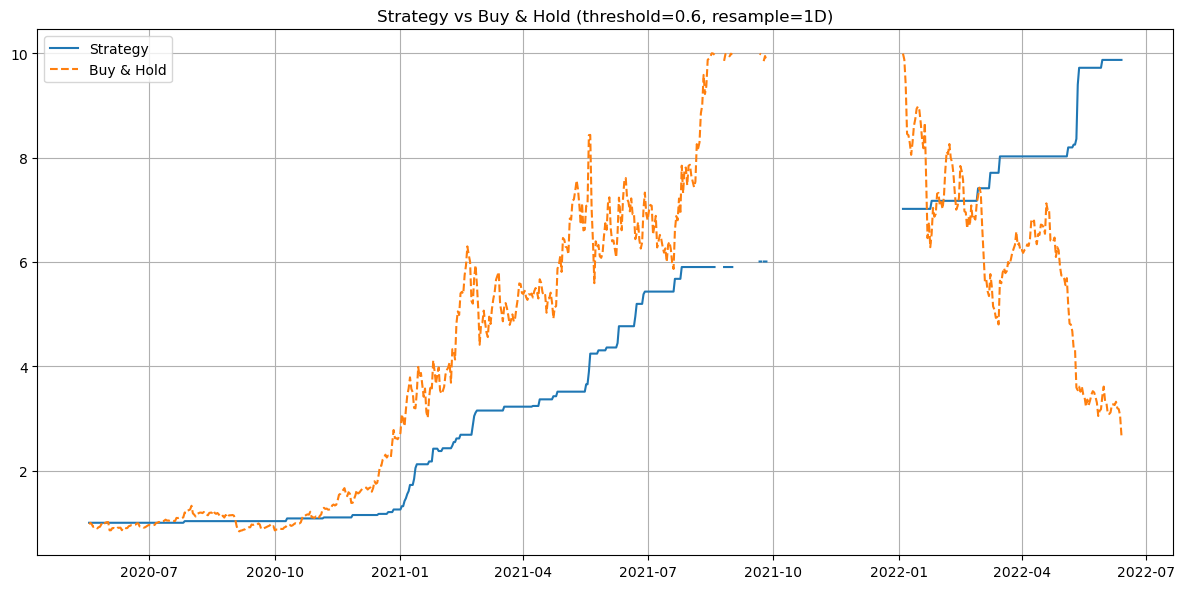

In [18]:
plot_strategy_vs_buy_hold(df_signals, threshold=0.6, resample='1D', show_signals=False)

## Получаем нвоые данные и предиктим наних

In [30]:
def get_btc():
    exchange = ccxt.binance()
    symbol = 'BTC/USDT'
    timeframe = '15m'  # сменили на 15 минут
    limit = 1000

    now = exchange.milliseconds()
    since = now - 7 * 24 * 60 * 60 * 1000  # 7 дней назад

    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

    # Сделать timestamp индексом
    df = df.set_index('Timestamp')

    return df


In [31]:
df=get_btc()
df

,Open,High,Low,Close,Volume
Timestamp,,,,,
2025-06-17 09:45:00,"106,264.94","106,284.49","106,069.55","106,160.57",281.62
2025-06-17 10:00:00,"106,160.58","106,248.43","106,040.00","106,088.17",169.11
2025-06-17 10:15:00,"106,088.17","106,168.28","106,028.00","106,099.18",126.93
2025-06-17 10:30:00,"106,099.17","106,100.00","105,721.29","105,790.40",344.48
2025-06-17 10:45:00,"105,790.40","105,964.10","105,756.32","105,956.01",157.84
...,...,...,...,...,...
2025-06-24 08:30:00,"105,066.81","105,167.24","104,876.47","105,044.21",193.68
2025-06-24 08:45:00,"105,044.22","105,109.71","104,915.06","104,996.77",91.03
2025-06-24 09:00:00,"104,996.78","105,288.88","104,968.25","105,105.60",158.97


In [32]:
df_new= compute_indicators_v6(df, kalman_smooth=True)

In [33]:
df_new

,Open,High,Low,Close,Volume,sma_1d,sma_1w,sma_signal,ema_crossover,rsi,...,momentum_lag1,momentum_lag2,momentum_lag3,cmf_lag1,cmf_lag2,cmf_lag3,future_return,target,candle_cluster,combined_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-06-17 09:45:00,"65,640.77","65,667.09","65,535.83","65,584.81",148.66,"65,584.81","96,547.91",0,0,99.60,...,"40,102.95","40,102.95","40,102.95",-0.13,-0.13,-0.13,0.61,1,0,0
2025-06-17 10:00:00,"90,657.36","90,716.78","90,537.93","90,593.87",164.36,"90,593.87","96,547.91",0,1,99.60,...,"40,102.95","40,102.95","40,102.95",-0.13,-0.13,-0.13,0.16,1,0,2
2025-06-17 10:15:00,"100,170.73","100,234.83","100,037.97","100,108.62",175.30,"100,108.62","96,547.91",0,1,99.60,...,"40,102.95","40,102.95","40,102.95",-0.13,-0.13,-0.13,0.05,1,0,2
2025-06-17 10:30:00,"103,766.65","103,819.43","103,547.99","103,632.82",234.62,"103,632.82","96,547.91",0,1,99.60,...,"40,102.95","40,102.95","40,102.95",-0.13,-0.13,-0.13,0.02,0,0,2
2025-06-17 10:45:00,"105,030.07","105,123.45","104,884.69","104,999.45",184.07,"104,999.45","96,547.91",0,1,99.60,...,"40,102.95","40,102.95","40,102.95",-0.13,-0.13,-0.13,0.01,0,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24 08:30:00,"105,027.76","105,166.48","104,848.63","105,044.82",196.23,"105,044.82","105,189.92",0,1,49.86,...,-343.41,-313.90,-100.23,0.04,0.01,0.01,0.00,0,2,2
2025-06-24 08:45:00,"105,044.91","105,195.60","104,914.76","105,062.53",147.11,"105,062.53","105,125.83",0,1,45.99,...,-386.60,-343.41,-313.90,0.06,0.04,0.01,0.00,0,5,2
2025-06-24 09:00:00,"105,062.74","105,310.59","104,980.59","105,146.00",154.06,"105,146.00","105,081.01",1,1,43.72,...,-444.28,-386.60,-343.41,0.07,0.06,0.04,0.00,0,5,2


In [7]:
df_new_with_kal = df_new.drop(columns=['future_return','High', 'Close', 'Low', 'Open']).copy()
scaler = joblib.load('scaler.save')
df_new_with_kal = df_new_with_kal.replace([np.inf, -np.inf], np.nan).dropna()

NameError: name 'df_new' is not defined

In [40]:
TIMESTEPS = 10
HORIZON = 96  # 1 день при 15-мин интервале

# Допустим, df_new_with_kal — твой очищенный DataFrame, индекс — Timestamp
# Отделяем признаки и таргет
X_new = df_new_with_kal.drop(columns=['target'])  # все колонки кроме таргета
y_new = df_new_with_kal['target']

# Если надо — масштабируем X_new (используя тот же scaler, что и на обучении)
# Например:
X_new_scaled = scaler.transform(X_new)

# Создаем последовательности (предполагается, что create_sequences принимает np.array)
X_seq, y_seq, ts_seq = create_sequences(
    X_new_scaled, 
    y_new.values, 
    TIMESTEPS, 
    horizon=HORIZON, 
    timestamps=df_new_with_kal.index
)

In [43]:
# Предполагаем, что X_seq и y_seq уже есть (numpy-массивы)
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

# Создаем датасет и DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)



In [48]:
# Отправляем тензоры на устройство
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

model10min_with_kal.to(device)
model10min_with_kal.eval()
with torch.no_grad():
    outputs = model10min_with_kal(X_tensor)  # X_seq_tensor — весь датасет батчей
    probs = torch.sigmoid(outputs).squeeze()
    preds = (probs >= 0.5).long()

# 2. Отбираем батчи для последнего дня
last_day = df_new_with_kal.index.date.max()
# ts_seq — список временных меток для каждого батча (например, первая метка батча)
indices_last_day = [i for i, ts in enumerate(ts_seq) if ts.date() == last_day]

# 3. Вычисляем среднюю вероятность и класс по последнему дню
probs_last_day = probs[indices_last_day]
preds_last_day = preds[indices_last_day]
avg_prob_last_day = probs_last_day.mean().item()
final_class_last_day = 1 if avg_prob_last_day >= 0.5 else 0

print(f"Средняя вероятность роста на последний день: {avg_prob_last_day:.4f}")
print(f"Предсказанный класс на последний день: {final_class_last_day}")

# 4. Анализ свечных паттернов из df_new_with_kal для последнего дня
df_last_day = df_new_with_kal[df_new_with_kal.index.date == last_day]
bullish_signals = df_last_day['combined_signal'].sum()  # пример подсчёта

# 5. Корректируем итог по паттернам
if bullish_signals > len(df_last_day) * 0.6:  # например, если более 60% свечей — бычьи
    print("Свечные паттерны указывают на рост, корректируем вероятность")
    avg_prob_last_day = min(1.0, avg_prob_last_day + 0.1)
    final_class_last_day = 1 if avg_prob_last_day >= 0.5 else 0

print(f"С учётом свечных паттернов вероятность: {avg_prob_last_day:.4f}")
print(f"Итоговый прогноз на последний день: {'Рост' if final_class_last_day == 1 else 'Падение'}")

Средняя вероятность роста на последний день: 0.0108
Предсказанный класс на последний день: 0
Свечные паттерны указывают на рост, корректируем вероятность
С учётом свечных паттернов вероятность: 0.1108
Итоговый прогноз на последний день: Падение


In [52]:
btc_with_ta

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,sma_1d,...,momentum_lag1,momentum_lag2,momentum_lag3,cmf_lag1,cmf_lag2,cmf_lag3,future_return,target,candle_cluster,combined_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-11 00:00:00,"5,398.69","5,437.34","5,394.51","5,410.82",645.73,"10,528,954.94",8989,636.99,"5,583,818.86","5,410.82",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.61,1,0,0
2020-05-11 00:15:00,"7,473.29","7,512.02","7,462.54","7,487.28",735.77,"6,864,492.57",8713,357.29,"3,135,830.40","7,487.28",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.16,1,0,2
2020-05-11 00:30:00,"8,275.25","8,302.48","8,247.17","8,272.67",779.39,"6,544,348.12",9044,329.34,"2,891,749.14","8,272.67",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.05,1,0,2
2020-05-11 00:45:00,"8,573.62","8,590.27","8,529.02","8,572.16",856.87,"9,463,730.78",8832,503.38,"4,396,292.27","8,572.16",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.02,0,0,2
2020-05-11 01:00:00,"8,687.17","8,698.02","8,643.90","8,673.65",707.50,"5,199,193.57",6208,236.29,"2,066,803.28","8,673.65",...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.01,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24 23:00:00,"105,955.85","105,994.48","105,831.36","105,910.14",58.22,"6,587,454.33",17053,30.29,"3,208,619.82","105,910.14",...,195.66,333.04,345.70,0.03,0.02,0.04,0.00,0,4,1
2025-06-24 23:15:00,"105,904.51","105,954.72","105,813.55","105,907.77",61.17,"5,749,910.45",12214,14.93,"1,579,963.57","105,907.77",...,42.42,195.66,333.04,0.05,0.03,0.02,0.00,0,4,1
2025-06-24 23:30:00,"105,893.03","106,005.01","105,834.40","105,975.29",70.97,"5,674,537.82",12562,19.19,"2,030,985.60","105,975.29",...,-47.46,42.42,195.66,0.07,0.05,0.03,0.00,0,4,2


In [4]:
# Удаляем ненужные колонки
df_clean = btc_with_ta.drop(columns=['future_return', 'High', 'Close', 'Low', 'Open', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume']).copy()

# Удаляем inf и NaN
df_clean = df_clean.replace([np.inf, -np.inf], np.nan).dropna()

# Проверим размерность
print("Shape after cleaning:", df_clean.shape)

Shape after cleaning: (179509, 75)


In [5]:
# Целевая переменная
y = df_clean['target'].values.astype(np.float32)

# Признаки
X = df_clean.drop(columns=['target']).values

# Масштабируем
scaler_ttf = StandardScaler()
X_scaled_ttf = scaler_ttf.fit_transform(X)
joblib.dump(scaler_ttf, 'scaler_ttf.save')


['scaler_ttf.save']

In [6]:
class SequenceDataset(Dataset):
    def __init__(self, X, y, timesteps, horizon=1, timestamps=None):
        self.X = X
        self.y = y
        self.timesteps = timesteps
        self.horizon = horizon
        self.timestamps = timestamps if timestamps is not None else range(len(X))

    def __len__(self):
        return len(self.X) - self.timesteps - self.horizon + 1

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx + self.timesteps]
        y_val = self.y[idx + self.timesteps + self.horizon - 1]
        timestamp = self.timestamps[idx + self.timesteps + self.horizon - 1]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32), timestamp

In [7]:
# --- Данные ---
TIMESTEPS = 672
HORIZON = 1
BATCH_SIZE = 128

dataset = SequenceDataset(X_scaled_ttf, y, TIMESTEPS, HORIZON, timestamps=df_clean.index)

In [8]:
# --- Разделение на train/val/test ---

# --- Разбиение ---
total_len = len(dataset)
train_len = int(0.6 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))


In [9]:
class BTCWindowDataset(Dataset):
    def __init__(self, df, encoder_length, prediction_length):
        self.encoder_length = encoder_length
        self.prediction_length = prediction_length
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df) - self.encoder_length - self.prediction_length

    def __getitem__(self, idx):
        x = self.df.iloc[idx : idx + self.encoder_length]
        y = self.df.iloc[idx + self.encoder_length : idx + self.encoder_length + self.prediction_length]
    
        # Оставляем только числовые колонки, исключая 'target'
        x = x.select_dtypes(include=[np.number]).drop(columns=['target'], errors='ignore').fillna(0)
    
        x_tensor = torch.tensor(x.values, dtype=torch.float)
        y_tensor = torch.tensor(y['target'].values, dtype=torch.float)
    
        return x_tensor, y_tensor


In [10]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4)

In [11]:
for x_batch, y_batch, ts_seq in train_dl:
    print("Batch X shape:", x_batch.shape)  # (batch_size, timesteps, features)
    break

input_size = x_batch.shape[2]
print("Input size for model:", input_size)

Batch X shape: torch.Size([128, 672, 74])
Input size for model: 74


In [12]:
class TransformerBinaryClassifier(LightningModule):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.embedding = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)
        self.lr = lr

    def forward(self, x):
        # x: (batch, seq_len, features)
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch, d_model)
        x = self.transformer(x)
        out = self.fc_out(x[-1])  # берем выход последнего шага последовательности
        return out.squeeze(-1)

    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        x = x.float()  # принудительно
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        x = x.float()
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        x = x.float()
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        self.log("test_loss", loss)
        # можно вернуть предсказания, если нужно
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [13]:
model = TransformerBinaryClassifier(input_size=X_scaled_ttf.shape[1])

# --- Тренировка ---
trainer = Trainer(
    max_epochs=70,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
)

trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

# --- Тест ---
trainer.test(model, dataloaders=test_dl)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | embedding   | Linear             | 4.8 K  | train
1 | transformer | TransformerEncoder | 562 K  | train
2 | fc_out      | Linear             | 65     | train
-----------------------------------------------------------
567 K     Trainable params
0         Non-trainable params
567 K     Total params
2.269     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=70` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03617823123931885    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.03617823123931885}]

In [14]:
torch.save(model.state_dict(), "transformer_binary_15min.pt")

Accuracy: 0.9921
F1-score: 0.0839
ROC AUC: 0.9037


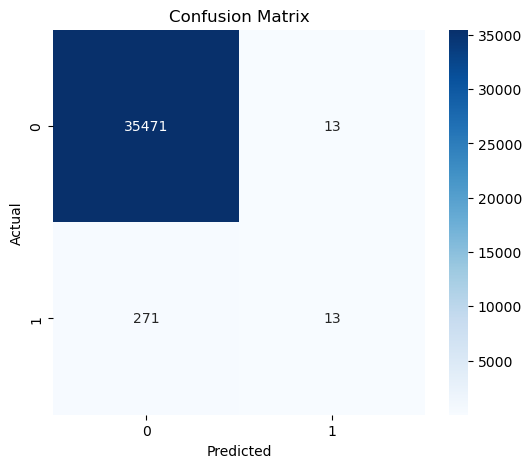

In [15]:

model.eval()  
all_preds = []
all_probas = []
all_targets = []

with torch.no_grad():
    for batch in test_dl:
       
        if len(batch) == 3:
            x, y, _ = batch
        else:
            x, y = batch
        
        x = x.float().to(model.device)
        y = y.to(model.device)
        
        logits = model(x)  # выход модели — логиты
        probas = torch.sigmoid(logits).squeeze()  # вероятности (для бинарной классификации)
        
        preds = (probas > 0.5).long()  # бинарные метки (0 или 1)
        
        all_preds.append(preds.cpu())
        all_probas.append(probas.cpu())
        all_targets.append(y.cpu())

# Склеиваем батчи
all_preds = torch.cat(all_preds).numpy()
all_probas = torch.cat(all_probas).numpy()
all_targets = torch.cat(all_targets).numpy()

# Считаем метрики
accuracy = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
roc_auc = roc_auc_score(all_targets, all_probas)
cm = confusion_matrix(all_targets, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Визуализация матрицы ошибок
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
btc_with_ta = btc_with_ta.drop(columns=['Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume'])

In [28]:
btc_with_ta

,Open,High,Low,Close,Volume,sma_1d,sma_1w,sma_signal,ema_crossover,rsi,...,momentum_lag1,momentum_lag2,momentum_lag3,cmf_lag1,cmf_lag2,cmf_lag3,future_return,target,candle_cluster,combined_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-11 00:00:00,"5,398.69","5,437.34","5,394.51","5,410.82",645.73,"5,410.82","7,977.35",0,0,98.73,...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.61,1,0,0
2020-05-11 00:15:00,"7,473.29","7,512.02","7,462.54","7,487.28",735.77,"7,487.28","7,977.35",0,1,98.73,...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.16,1,0,2
2020-05-11 00:30:00,"8,275.25","8,302.48","8,247.17","8,272.67",779.39,"8,272.67","7,977.35",0,1,98.73,...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.05,1,0,2
2020-05-11 00:45:00,"8,573.62","8,590.27","8,529.02","8,572.16",856.87,"8,572.16","7,977.35",0,1,98.73,...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.02,0,0,2
2020-05-11 01:00:00,"8,687.17","8,698.02","8,643.90","8,673.65",707.50,"8,673.65","7,977.35",0,1,98.73,...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.01,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24 23:00:00,"105,955.85","105,994.48","105,831.36","105,910.14",58.22,"105,910.14","105,934.89",0,1,80.84,...,195.66,333.04,345.70,0.03,0.02,0.04,0.00,0,4,1
2025-06-24 23:15:00,"105,904.51","105,954.72","105,813.55","105,907.77",61.17,"105,907.77","105,930.60",0,1,77.90,...,42.42,195.66,333.04,0.05,0.03,0.02,0.00,0,4,1
2025-06-24 23:30:00,"105,893.03","106,005.01","105,834.40","105,975.29",70.97,"105,975.29","105,934.34",1,1,79.55,...,-47.46,42.42,195.66,0.07,0.05,0.03,0.00,0,4,2


In [7]:
# Удаляем inf и NaN
btc_with_ta = btc_with_ta.replace([np.inf, -np.inf], np.nan).dropna()

# Проверим размерность
print("Shape after cleaning:", btc_with_ta.shape)

Shape after cleaning: (179509, 80)


🧭 Шаг 1: Постановка задачи RL
Сформулируем основную идею:

Агент смотрит на текущие признаки рынка и решает: покупать, продавать или держать. Его цель — максимизировать прибыль на всём отрезке.
🔁 RL как среда
В RL ты должен:
- Определить state — что агент видит.
- Определить action — что он может делать.
- Определить reward — что он получает за действие.
- Создать environment (среду) — как агент взаимодействует с историей.

✅ Шаг 2: Определим state

In [8]:
excluded = ['future_return', 'target']
state_columns = [col for col in btc_with_ta.columns if col not in excluded]
state_df = btc_with_ta[state_columns].copy()

✅ Шаг 3: Определим action
- 0 = Hold
- 1 = Buy (войти в long-позицию) только 1 раз
- 2 = Sell (выйти из позиции)


In [9]:
action_space = gym.spaces.Discrete(3)

✅ Шаг 4: Определим reward
| Подход                        | Reward                        |
| ----------------------------- | ----------------------------- |
| 📈 Доходность сделки          | `log(price_now / price_prev)` |
| 💰 Изменение капитала         | `equity[t+1] - equity[t]`     |
| 🔄 Reward за закрытие позиции | Только при `Sell`: `PnL`      |
| 🧠 Более сложно               | `Sharpe`, `Sortino`, drawdown |

- Если нет позиции — reward = 0
- Если держим позицию — reward = доход за шаг
- Можно ввести penalty за чрезмерные сделки (комиссии)


In [19]:

class BTCTradingEnv(gym.Env):
    def __init__(self, df, state_columns,
             initial_balance=10_000,
             trade_penalty=0.01,
             max_steps=None,
             reward_scaling=100.0,
             use_log_return=False,
             use_sharpe_bonus=False,
             holding_penalty=0.005,
             sharpe_bonus_weight=0.5,
             commission=0.0005,
             spread=0.0002,
             slippage_std=0.001,
             min_holding_period=8,
             window_size=672):

        super().__init__()
        self.df = df.reset_index(drop=True)
        self.state_columns = state_columns
        self.window_size = window_size

        self.commission = commission
        self.spread = spread
        self.slippage_std = slippage_std
        self.min_holding_period = min_holding_period

        self.action_space = gym.spaces.Discrete(3)  # 0: hold, 1: buy, 2: sell
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(window_size, len(state_columns)),
            dtype=np.float32
        )

        self.initial_balance = initial_balance
        self.trade_penalty = trade_penalty
        self.reward_scaling = reward_scaling
        self.max_steps = max_steps if max_steps is not None else len(df) - 1

        self.use_log_return = use_log_return
        self.use_sharpe_bonus = use_sharpe_bonus
        self.holding_penalty = holding_penalty
        self.sharpe_bonus_weight = sharpe_bonus_weight

        self.all_trades_info = []
        self.episode_trades_info = []
        self.negative_steps_log = []

        self.reset()

    def _get_execution_price(self, price, action):
        if action == 1:
            exec_price = price * (1 + self.spread)
        elif action == 2:
            exec_price = price * (1 - self.spread)
        else:
            exec_price = price

        slippage = np.random.normal(0, self.slippage_std)
        exec_price *= (1 + slippage)
        return max(exec_price, 0.0001)

    def save_negative_steps(self, path="negative_steps_log.csv"):
        if self.negative_steps_log:
            df_neg = pd.DataFrame(self.negative_steps_log)
            df_neg.to_csv(path, index=False)
            print(f"[✓] Сохранён лог негативных шагов в {path}")
        else:
            print("[i] Нет негативных шагов для сохранения.")

    def _next_observation(self):
        obs = self.df.iloc[self.current_step][self.state_columns].astype(np.float32).values
        obs = np.nan_to_num(obs)
        self.state_window.append(obs)
        return np.array(self.state_window)

    def _calculate_equity(self, current_price):
        if self.position == 1:
            return self.balance + (current_price - self.entry_price)
        return self.balance

    def _calculate_max_drawdown(self):
        equity = np.array(self.equity_curve)
        if len(equity) < 2:
            return 0
        cumulative_max = np.maximum.accumulate(equity)
        drawdowns = (equity - cumulative_max) / cumulative_max
        return drawdowns.min()

    def reset(self, *, seed=None, options=None):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0
        self.entry_price = 0.0
        self.entry_step = None
        self.total_reward = 0.0
        self.trades = []
        self.trades_info = []
        self.equity_curve = [self.balance]
        self.episode_trades_info = []
        self.actions_log = []
        self.state_window = deque(maxlen=self.window_size)
        self.invalid_sell_count = 0
        self.invalid_buy_count = 0
        self.negative_steps_log = []

        for i in range(self.current_step - self.window_size, self.current_step):
            obs = self.df.iloc[i][self.state_columns].astype(np.float32).values
            self.state_window.append(np.nan_to_num(obs))

        return self._next_observation(), {}

    def step(self, action):
        done = False
        reward = 0.0
    
        market_price = self.df.loc[self.current_step, 'Close']
        if np.isnan(market_price) or market_price <= 0:
            market_price = 1.0
    
        max_holding_period = 96
        if self.position == 1 and (self.current_step - self.entry_step) >= max_holding_period:
            action = 2  # форсированная продажа
    
        exec_price = self._get_execution_price(market_price, action)
    
        # --- BUY ---
        if action == 1:
            if self.position == 0:
                commission_cost = exec_price * self.commission
                reward += 0.2
                self.position = 1
                self.entry_price = exec_price + commission_cost
                self.entry_step = self.current_step
                self.balance -= commission_cost
            else:
                self.invalid_buy_count += 1
                reward -= 0.01 * self.invalid_buy_count
    
        # --- SELL ---
        elif action == 2:
            if self.position == 1:
                commission_cost = exec_price * self.commission
                price_change = (exec_price - self.entry_price) / self.entry_price
                holding_duration = self.current_step - self.entry_step
    
                reward = price_change * 100
                reward -= self.commission * 2
                reward += 0.3
    
                if holding_duration < self.min_holding_period:
                    reward -= 0.05
    
                self.balance += price_change * self.entry_price
                self.balance -= commission_cost
    
                trade_info = {
                    "entry_step": self.entry_step,
                    "exit_step": self.current_step,
                    "profit": price_change - self.commission * 2,
                    "holding": holding_duration,
                    "entry_price": self.entry_price,
                    "exit_price": exec_price
                }
                self.trades.append(trade_info["profit"])
                self.episode_trades_info.append(trade_info)
                self.all_trades_info.append(trade_info)
    
                self.position = 0
                self.entry_price = 0.0
                self.entry_step = None
            else:
                self.invalid_sell_count += 1
                reward -= 0.01 * self.invalid_sell_count
    
        # --- HOLD ---
        elif action == 0:
            if self.position == 1:
                unrealized = (market_price - self.entry_price) / self.entry_price
                reward += unrealized * 0.1
    
                holding_duration = self.current_step - self.entry_step
                if holding_duration > self.min_holding_period:
                    reward -= self.holding_penalty * 0.5 * max(0, holding_duration - self.min_holding_period)
            else:
                reward -= 0.001
    
        # --- Reset bad action counters if action was good ---
        if (action == 1 and self.position == 0) or (action == 2 and self.position == 1) or action == 0:
            self.invalid_sell_count = 0
            self.invalid_buy_count = 0
    
        # --- Clip and finalize ---
        reward = np.clip(reward, -100.0, 100.0)
        if np.isnan(reward) or np.isinf(reward):
            reward = 0.0
    
        equity = self._calculate_equity(market_price)
        self.total_reward += reward
        self.equity_curve.append(equity)
    
        obs = self._next_observation()
        self.current_step += 1
        done = self.current_step >= self.max_steps
    
        # --- Force close ---
        if done and self.position == 1:
            exec_price = self._get_execution_price(market_price, 2)
            commission_cost = exec_price * self.commission
            final_price_change = (exec_price - self.entry_price) / self.entry_price - self.commission * 2
            final_reward = final_price_change
    
            self.balance += final_price_change * self.entry_price
            self.balance -= commission_cost
    
            trade_info = {
                "entry_step": self.entry_step,
                "exit_step": self.current_step,
                "profit": final_price_change,
                "holding": self.current_step - self.entry_step,
                "entry_price": self.entry_price,
                "exit_price": exec_price
            }
            self.trades.append(final_price_change)
            self.episode_trades_info.append(trade_info)
            self.all_trades_info.append(trade_info)
    
            self.total_reward += final_reward * self.reward_scaling
            self.position = 0
    
        # --- Sharpe bonus ---
        if done and self.use_sharpe_bonus and len(self.trades) > 1:
            sharpe = np.mean(self.trades) / (np.std(self.trades) + 1e-8)
            reward += self.sharpe_bonus_weight * sharpe
    
        self.actions_log.append(action)
    
        # --- INFO ---
        info = {
            'balance': self.balance,
            'equity': equity,
            'position': self.position,
            'step': self.current_step,
            'reward': reward,
            'drawdown': self._calculate_max_drawdown(),
            'total_profit': np.sum(self.trades),
            'recent_trade': self.episode_trades_info[-1] if self.episode_trades_info else None,
            'entry_price': self.entry_price if self.position == 1 else None,
            'unrealized_profit': ((market_price - self.entry_price) / self.entry_price) if self.position == 1 else 0.0,
            'holding_duration': (self.current_step - self.entry_step) if self.position == 1 else 0,
            'actions_log': self.actions_log[-100:]
        }
    
        if done and self.episode_trades_info:
            profits = [t["profit"] for t in self.episode_trades_info]
            durations = [t["holding"] for t in self.episode_trades_info]
    
            avg_profit = np.mean(profits)
            avg_duration = np.mean(durations)
            sharpe_ratio = np.mean(profits) / (np.std(profits) + 1e-8)
    
            tp = sum(1 for p in profits if p > 0)
            fp = sum(1 for p in profits if p <= 0)
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (len(profits) + 1e-8)
    
            info.update({
                "avg_trade_profit": avg_profit,
                "avg_holding_duration": avg_duration,
                "sharpe_ratio": sharpe_ratio,
                "precision": precision,
                "recall": recall,
                "f1_score": 2 * precision * recall / (precision + recall + 1e-8)
            })
    
        if reward < 0:
            self.negative_steps_log.append({
                "step": self.current_step,
                "reward": reward,
                "action": action,
                "position": self.position,
                "balance": self.balance,
                "equity": equity,
            })
    
        return obs, reward, done, False, info

In [20]:
class SharpeEarlyStopCallback(BaseCallback):
    def __init__(self, threshold=-1.0, verbose=0):
        super().__init__(verbose)
        self.threshold = threshold

    def _on_step(self) -> bool:
        if len(self.training_env.get_attr("trades")[0]) > 10:
            trades = self.training_env.get_attr("trades")[0]
            sharpe = np.mean(trades) / (np.std(trades) + 1e-8)
            if sharpe < self.threshold:
                print(f"⛔️ Early stopping: Sharpe={sharpe:.3f} < {self.threshold}")
                return False
        return True

In [21]:
class TransformerFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        # Определим размеры входа
        seq_len, feature_dim = observation_space.shape  # (window_size, num_features)

        super().__init__(observation_space, features_dim=d_model)

        self.seq_len = seq_len
        self.feature_dim = feature_dim

        # Линейный слой для увеличения размерности признаков до d_model
        self.input_proj = nn.Linear(feature_dim, d_model)

        self.norm = nn.LayerNorm(d_model)

        # Трансформер-энкодер
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Агрегация выходов трансформера (например, берём последний токен)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch_size, seq_len, feature_dim)
        x = self.input_proj(x)  # -> (batch_size, seq_len, d_model)
        x = self.norm(x)  # 👈 после линейного слоя
        x = self.transformer_encoder(x)  # -> (batch_size, seq_len, d_model)

        # Берём среднее по временной оси: (batch_size, d_model)
        x = x.mean(dim=1)
        return x

In [22]:
class TransformerPolicy(ActorCriticPolicy):
    def __init__(self, observation_space, action_space, lr_schedule,
                 net_arch=None, activation_fn=nn.Tanh, **kwargs):

        # Заменим feature_extractor на наш TransformerFeatureExtractor
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            features_extractor_class=TransformerFeatureExtractor,
            features_extractor_kwargs=dict(d_model=64, nhead=4, num_layers=2),
            net_arch=[dict(pi=[64], vf=[64])],
            activation_fn=activation_fn,
            **kwargs
        )

In [40]:

def make_env():
    return BTCTradingEnv(
        df=btc_with_ta,
        state_columns=state_columns,
        initial_balance=5000,
        trade_penalty=0.01,
        max_steps=2000,
        reward_scaling=100,
        window_size=672  # 7 дней по 15 минут
    )

vec_env = DummyVecEnv([make_env])

In [41]:
# 3. Обучим агента
model = PPO(
    policy=TransformerPolicy,
    env=vec_env,
    verbose=1,
    n_steps=4096,
    batch_size=64,
    gae_lambda=0.95,
    gamma=0.99,
    n_epochs=10,
    learning_rate=3e-4,
    clip_range=0.2,           # 👈 обязательно
    max_grad_norm=0.5,        # 👈 ограничим градиенты
    vf_coef=0.5,
    normalize_advantage=True,
    ent_coef=0.2  # <-- Ключевой параметр для стимула к исследованию
)
model.learn(total_timesteps=300_000, progress_bar=True)



Using cuda device


Output()

-----------------------------
| time/              |      |
|    fps             | 185  |
|    iterations      | 1    |
|    time_elapsed    | 22   |
|    total_timesteps | 4096 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 2           |
|    time_elapsed         | 196         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012715817 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.603       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.246      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0159     |
|    value_loss           | 0.00806     |
-----------------------------------------
----------------------------------

In [42]:
model.save("ppo_btc_trading_v12")

In [14]:
model = PPO.load("ppo_btc_trading_v12", env=vec_env)

In [43]:
obs = vec_env.reset()
done = False

balances = []
positions = []
rewards = []
steps = []
equities = []

total_reward = 0
step_idx = 0
num_trades = 0
last_position = 0

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)

    balance = info[0]['balance']
    position = info[0]['position']
    equity = info[0].get('equity', balance)  # fallback на balance

    balances.append(balance)
    positions.append(position)
    rewards.append(reward[0])
    equities.append(equity)
    steps.append(step_idx)

    # Считаем сделки — смена позиции
    if position != last_position:
        num_trades += 1
        last_position = position

    total_reward += reward[0]
    step_idx += 1

print(f"✅ Total reward for episode: {total_reward:.2f}")
print(f"🔁 Total trades executed: {num_trades}")

# --- Метрики ---
if len(equities) > 1:
    equity_array = np.array(equities)
    max_dd = np.max(np.maximum.accumulate(equity_array) - equity_array)
    sharpe = np.mean(rewards) / (np.std(rewards) + 1e-8)

    print(f"📉 Max drawdown: {max_dd:.2f}")
    if len(rewards) > 1:
        print(f"📈 Sharpe Ratio: {sharpe:.2f}")

# Сохраняем в CSV
df_log = pd.DataFrame({
    'step': steps,
    'balance': balances,
    'equity': equities,
    'position': positions,
    'reward': rewards
})
df_log.to_csv('episode_run_log.csv', index=False)
print("Логи эпизода сохранены в episode_run_log.csv")

✅ Total reward for episode: -42.93
🔁 Total trades executed: 26
📉 Max drawdown: 1141.89
📈 Sharpe Ratio: -0.36
Логи эпизода сохранены в episode_run_log.csv


In [44]:
print("Шаги с отрицательной наградой (ошибки):")
for i, r in enumerate(rewards):
    if r < 0:
        print(f"Step {i}: reward {r:.4f}, position={positions[i]}, balance={balances[i]:.2f}")


Шаги с отрицательной наградой (ошибки):
Step 0: reward -0.0010, position=0, balance=5000.00
Step 1: reward -0.0010, position=0, balance=5000.00
Step 2: reward -0.0010, position=0, balance=5000.00
Step 3: reward -0.0010, position=0, balance=5000.00
Step 4: reward -0.0010, position=0, balance=5000.00
Step 5: reward -0.0010, position=0, balance=5000.00
Step 6: reward -0.0010, position=0, balance=5000.00
Step 7: reward -0.0010, position=0, balance=5000.00
Step 8: reward -0.0010, position=0, balance=5000.00
Step 9: reward -0.0010, position=0, balance=5000.00
Step 10: reward -0.0010, position=0, balance=5000.00
Step 11: reward -0.0010, position=0, balance=5000.00
Step 13: reward -0.0050, position=1, balance=4990.11
Step 14: reward -0.0050, position=1, balance=4990.11
Step 15: reward -0.0050, position=1, balance=4990.11
Step 16: reward -0.0050, position=1, balance=4990.11
Step 17: reward -0.0050, position=1, balance=4990.11
Step 18: reward -0.0050, position=1, balance=4990.11
Step 19: reward 

In [45]:
episode_summary = {
    'total_reward': total_reward,
    'total_trades': num_trades,
    'avg_reward': np.mean(rewards),
    'sharpe': sharpe if len(rewards) > 1 else None,
    'max_drawdown': max_dd,
    'final_balance': balances[-1],
    'final_equity': equities[-1],
}
pd.DataFrame([episode_summary]).to_csv("episode_summary.csv", index=False)

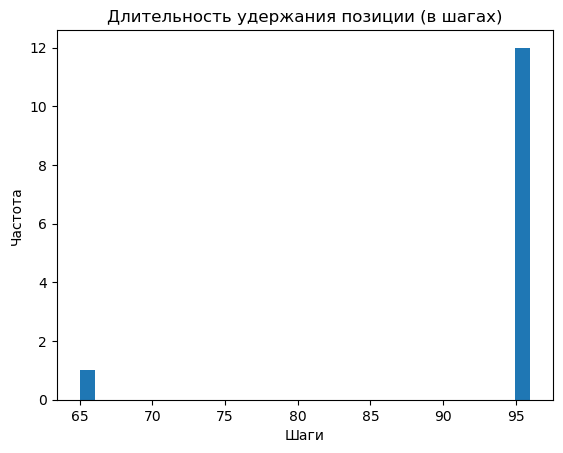

In [46]:
hold_lengths = []
current_hold = 0

for pos in positions:
    if pos == 1:
        current_hold += 1
    else:
        if current_hold > 0:
            hold_lengths.append(current_hold)
            current_hold = 0

plt.hist(hold_lengths, bins=30)
plt.title("Длительность удержания позиции (в шагах)")
plt.xlabel("Шаги")
plt.ylabel("Частота")
plt.show()

In [21]:

def analyze_episode(log_path="episode_run_log.csv", trades_info=None, df_full=None, initial_balance=10_000):
    # --- Загружаем лог эпизода ---
    df_log = pd.read_csv(log_path)

    steps = df_log['step']
    balances = df_log['balance']
    equities = df_log['equity']
    rewards = df_log['reward']
    positions = df_log['position']
    cumulative_rewards = np.cumsum(rewards)

    # --- Метрики ---
    total_reward = rewards.sum()
    num_trades = int(np.sum(np.abs(np.diff(positions)) > 0))
    sharpe = np.mean(rewards) / (np.std(rewards) + 1e-8) if len(rewards) > 1 else 0
    max_dd = np.max(np.maximum.accumulate(equities) - equities)

    print(f"✅ Total reward: {total_reward:.2f}")
    print(f"🔁 Total trades executed: {num_trades}")
    print(f"📉 Max drawdown: {max_dd:.2f}")
    print(f"📈 Sharpe Ratio: {sharpe:.2f}")

    # --- Сохраняем метрики ---
    summary = pd.DataFrame([{
        'total_reward': total_reward,
        'total_trades': num_trades,
        'avg_reward': np.mean(rewards),
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'final_balance': balances.iloc[-1],
        'final_equity': equities.iloc[-1],
    }])
    summary.to_csv("episode_summary.csv", index=False)

    # --- Графики ---
    plt.figure(figsize=(14, 12))

    plt.subplot(5, 1, 1)
    plt.plot(steps, balances, label='Balance')
    plt.title('Баланс на каждом шаге')
    plt.xlabel('Step')
    plt.ylabel('Balance')
    plt.legend()

    plt.subplot(5, 1, 2)
    plt.plot(steps, positions, label='Position')
    plt.title('Позиция агента (0=Hold, 1=Long)')
    plt.xlabel('Step')
    plt.ylabel('Position')
    plt.yticks([0, 1])
    plt.legend()

    plt.subplot(5, 1, 3)
    plt.plot(steps, rewards, label='Reward')
    plt.title('Награда агента по шагам')
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.legend()

    plt.subplot(5, 1, 4)
    plt.plot(steps, balances, label='Balance')
    plt.plot(steps, equities, label='Equity')
    plt.title('📉 Equity и баланс за эпизод')
    plt.xlabel('Step')
    plt.ylabel('USD')
    plt.legend()
    plt.grid(True)

    plt.subplot(5, 1, 5)
    plt.plot(steps, cumulative_rewards, label='Кумулятивная прибыль')
    plt.title('Кумулятивная прибыль')
    plt.xlabel('Step')
    plt.ylabel('Profit')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig("episode_plots.png")
    plt.show()

    # --- Сравнение с Buy & Hold ---
    if df_full is not None:
        plt.figure(figsize=(12, 6))
        bh_equity = df_full['Close'].iloc[:len(steps)] / df_full['Close'].iloc[0] * initial_balance
        plt.plot(steps, equities, label='RL Strategy')
        plt.plot(steps, bh_equity, label='Buy & Hold', linestyle='--')
        plt.title("📊 RL стратегия vs Buy & Hold")
        plt.xlabel("Шаг")
        plt.ylabel("USD")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig("rl_vs_hold.png")
        plt.show()

    # --- Анализ сделок ---
    if trades_info:
        trades_df = pd.DataFrame(trades_info)
        trades_df['duration'] = trades_df['exit_step'] - trades_df['entry_step']
        trades_df.to_csv("trades.csv", index=False)

        print(f"\nОбщее число сделок: {len(trades_df)}")
        print(f"Средняя длительность сделки (в шагах): {trades_df['duration'].mean():.2f}")
        print(f"Средняя прибыль на сделку: {trades_df['profit'].mean():.2f}")
        print(f"Суммарная прибыль: {trades_df['profit'].sum():.2f}")

        # Гистограмма прибыли
        plt.figure(figsize=(12, 4))
        plt.hist(trades_df['profit'], bins=30, color='blue', alpha=0.7)
        plt.title("Распределение прибыли по сделкам")
        plt.xlabel("Прибыль")
        plt.ylabel("Частота")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("trade_profit_hist.png")
        plt.show()

    # # Цена BTC с входами/выходами
    # if df_full is not None:
    #     plt.figure(figsize=(14, 6))
    #     plt.plot(df_full.index, df_full['Close'], label='Цена BTC', color='black', alpha=0.6)

    #     for trade in trades_info:
    #         entry = trade['entry_step']
    #         exit_ = trade['exit_step']
    #         profit = trade['profit']
    #         color = 'green' if profit >= 0 else 'red'
    #         plt.axvline(df_full.index[entry], color=color, linestyle='--', alpha=0.5)
    #         plt.axvline(df_full.index[exit_], color=color, linestyle=':', alpha=0.5)

    #     plt.title("📈 Цена BTC с точками входа/выхода")
    #     plt.xlabel("Время")
    #     plt.ylabel("Цена")
    #     plt.grid(True)
    #     plt.legend()
    #     plt.tight_layout()
    #     plt.savefig("btc_price_with_trades.png")
    #     plt.show()

✅ Total reward: -42.93
🔁 Total trades executed: 26
📉 Max drawdown: 1141.89
📈 Sharpe Ratio: -0.36


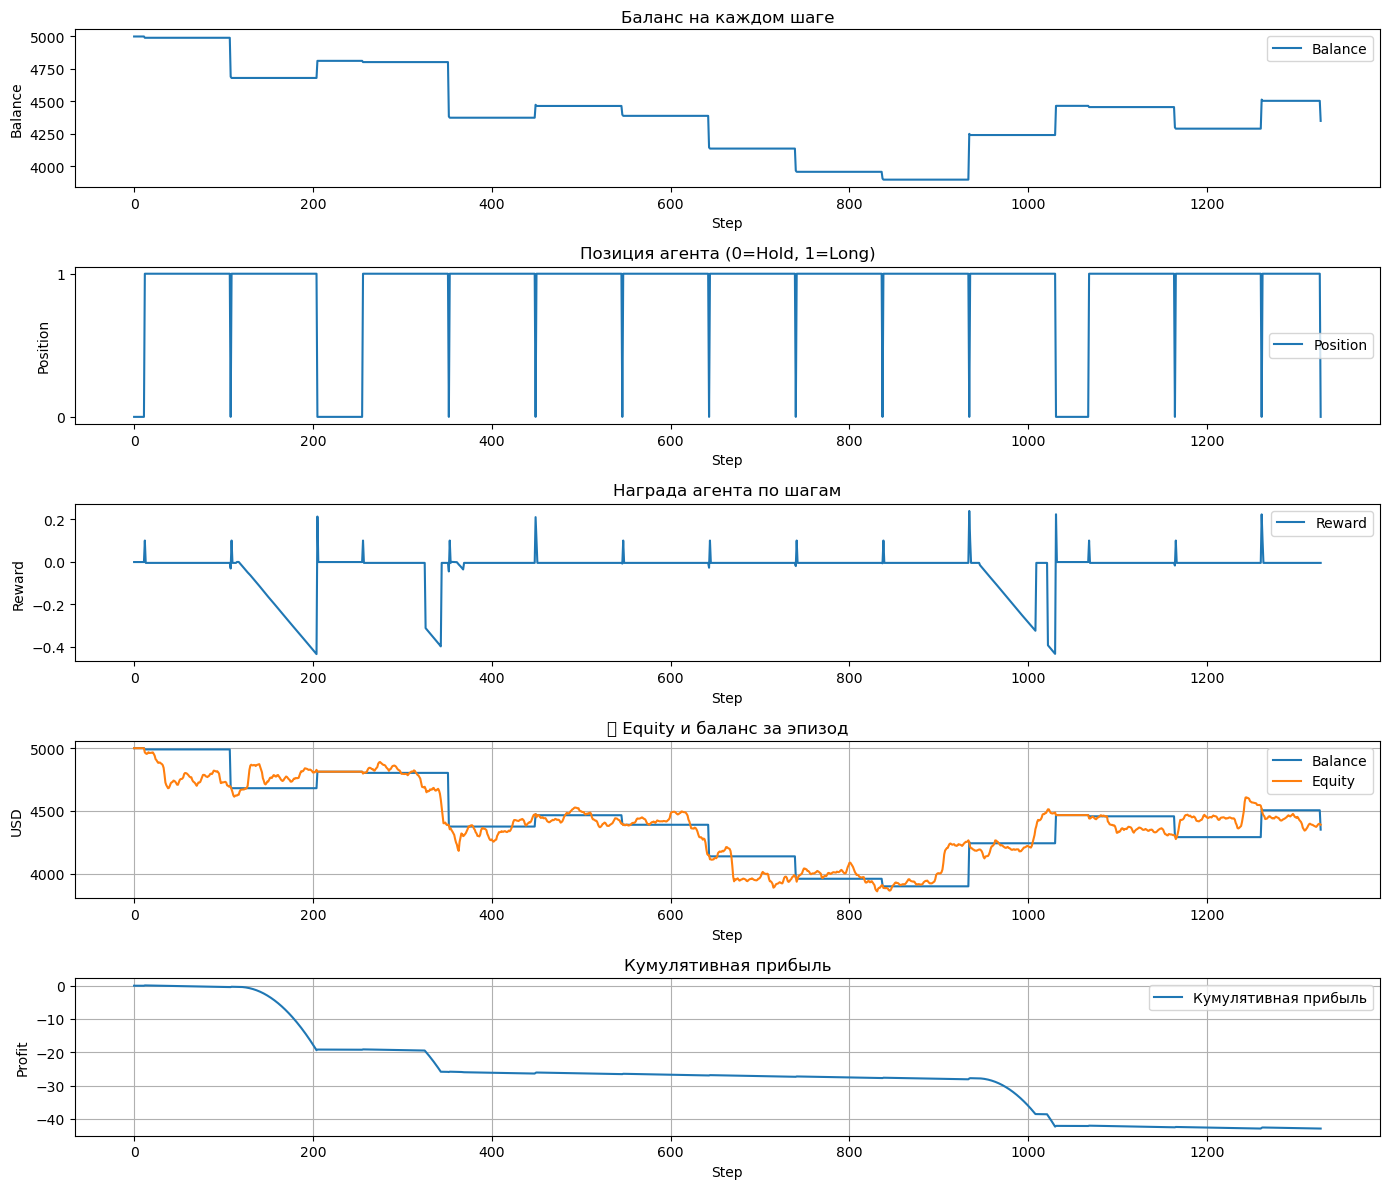

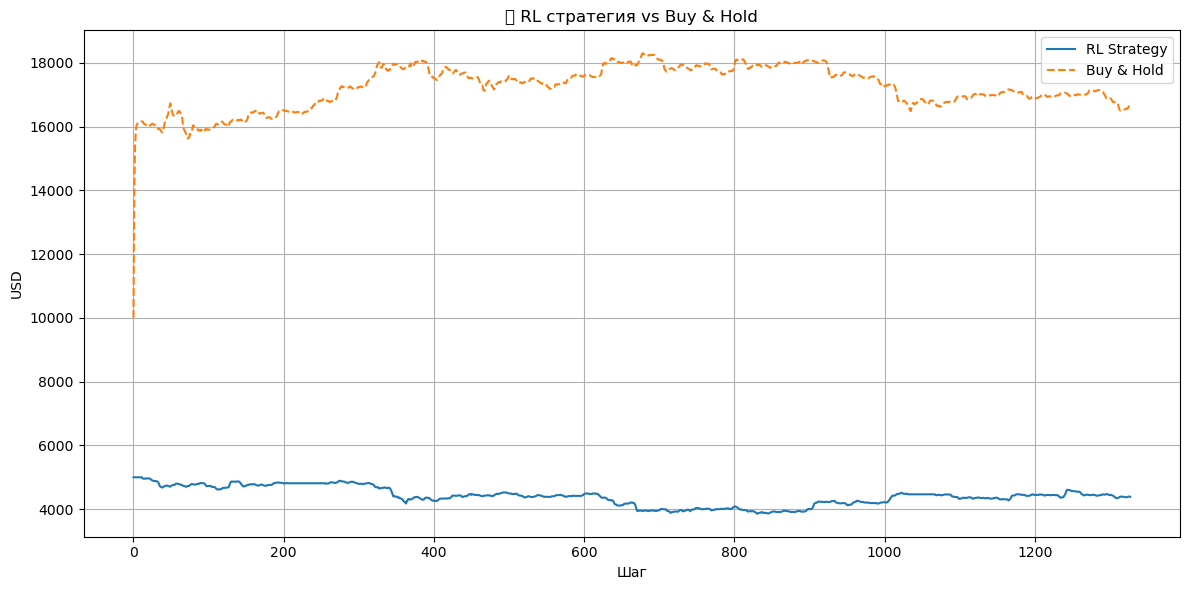


Общее число сделок: 42594
Средняя длительность сделки (в шагах): 4.79
Средняя прибыль на сделку: -0.00
Суммарная прибыль: -173.20


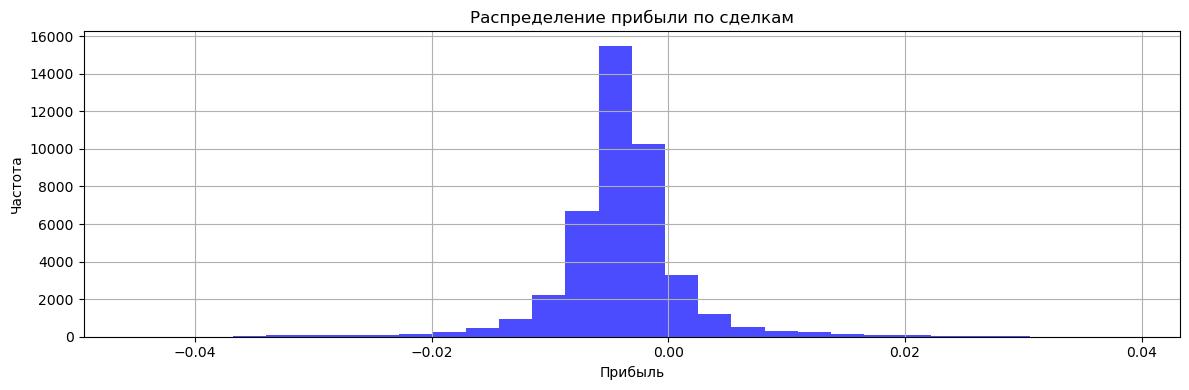

In [48]:
all_trades = vec_env.envs[0].all_trades_info
analyze_episode(
    log_path="episode_run_log.csv",
    trades_info=all_trades,
    df_full=btc_with_ta  # или df, где есть .index и 'Close'
)

In [20]:
def analyze_summary_metrics(run_logs: list[pd.DataFrame], trades_infos: list[list[dict]]):
    rewards_all = []
    sharpe_all = []
    drawdowns_all = []
    num_trades_all = []
    avg_pnl_all = []
    avg_duration_all = []

    for log_df, trades in zip(run_logs, trades_infos):
        # === Награды и Sharpe ===
        rewards = log_df['reward'].values
        total_reward = np.sum(rewards)
        sharpe = np.mean(rewards) / (np.std(rewards) + 1e-8)
        equity = log_df['equity'].values
        max_dd = np.max(np.maximum.accumulate(equity) - equity)

        rewards_all.append(total_reward)
        sharpe_all.append(sharpe)
        drawdowns_all.append(max_dd)

        # === Trades ===
        trades_df = pd.DataFrame(trades)
        num_trades_all.append(len(trades_df))
        avg_pnl_all.append(trades_df['profit'].mean() if not trades_df.empty else 0)
        avg_duration_all.append(trades_df['exit_step'].sub(trades_df['entry_step']).mean() if not trades_df.empty else 0)

    print("📊 Метрики по всем эпизодам:")
    print(f"▶ Средняя Total Reward: {np.mean(rewards_all):.2f}")
    print(f"▶ Средний Sharpe Ratio: {np.mean(sharpe_all):.2f}")
    print(f"▶ Средний Max Drawdown: {np.mean(drawdowns_all):.2f}")
    print(f"▶ Среднее число сделок: {np.mean(num_trades_all):.2f}")
    print(f"▶ Средняя прибыль на сделку: {np.mean(avg_pnl_all):.2f}")
    print(f"▶ Средняя длительность сделки: {np.mean(avg_duration_all):.2f} шагов")

    # --- Визуализация ---
    fig, axs = plt.subplots(2, 3, figsize=(16, 8))

    axs[0,0].boxplot(rewards_all)
    axs[0,0].set_title('🎯 Total Reward')
    
    axs[0,1].boxplot(sharpe_all)
    axs[0,1].set_title('📈 Sharpe Ratio')
    
    axs[0,2].boxplot(drawdowns_all)
    axs[0,2].set_title('📉 Max Drawdown')
    
    axs[1,0].boxplot(num_trades_all)
    axs[1,0].set_title('💼 Num Trades')
    
    axs[1,1].boxplot(avg_pnl_all)
    axs[1,1].set_title('💰 Avg PnL per Trade')
    
    axs[1,2].boxplot(avg_duration_all)
    axs[1,2].set_title('⏱️ Avg Trade Duration')

    plt.tight_layout()
    plt.show()

📊 Метрики по всем эпизодам:
▶ Средняя Total Reward: -42.92
▶ Средний Sharpe Ratio: -0.36
▶ Средний Max Drawdown: 1150.06
▶ Среднее число сделок: 42607.00
▶ Средняя прибыль на сделку: -0.00
▶ Средняя длительность сделки: 4.82 шагов


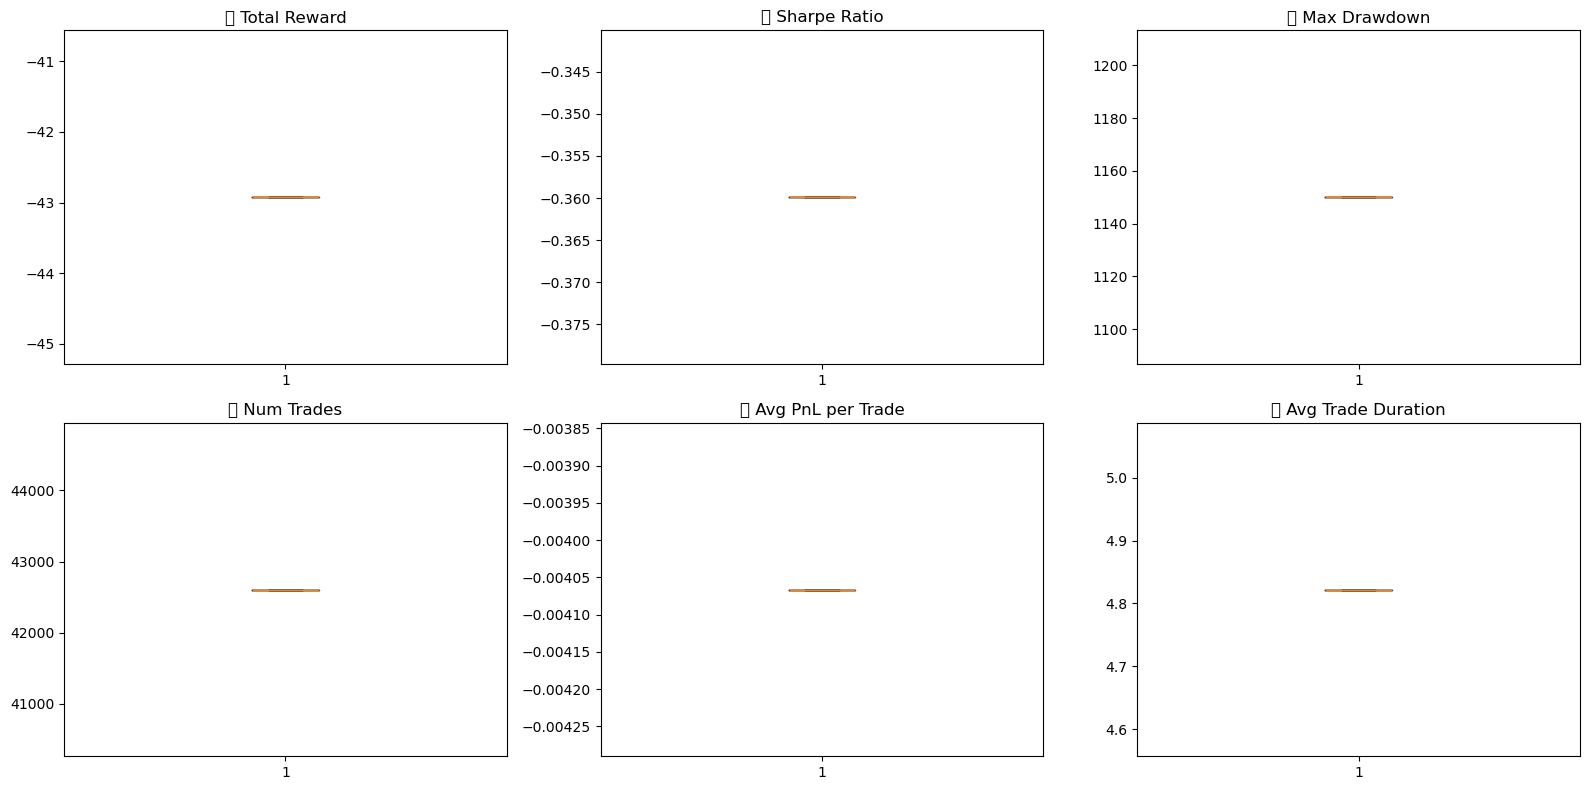

In [50]:
run_logs = []
trades_infos = []

obs = vec_env.reset()
log = {"balance": [], "equity": [], "reward": [], "position": [], "step": []}
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    info = info[0]

    for key in log:
        if key == "reward":
            log[key].append(reward[0])
        else:
            log[key].append(info[key])

run_logs.append(pd.DataFrame(log))

# Вместо trades_infos.append(...)
trades_infos.append(vec_env.envs[0].all_trades_info)  # Без цикла

# --- Анализ всех эпизодов ---
analyze_summary_metrics(run_logs, trades_infos)

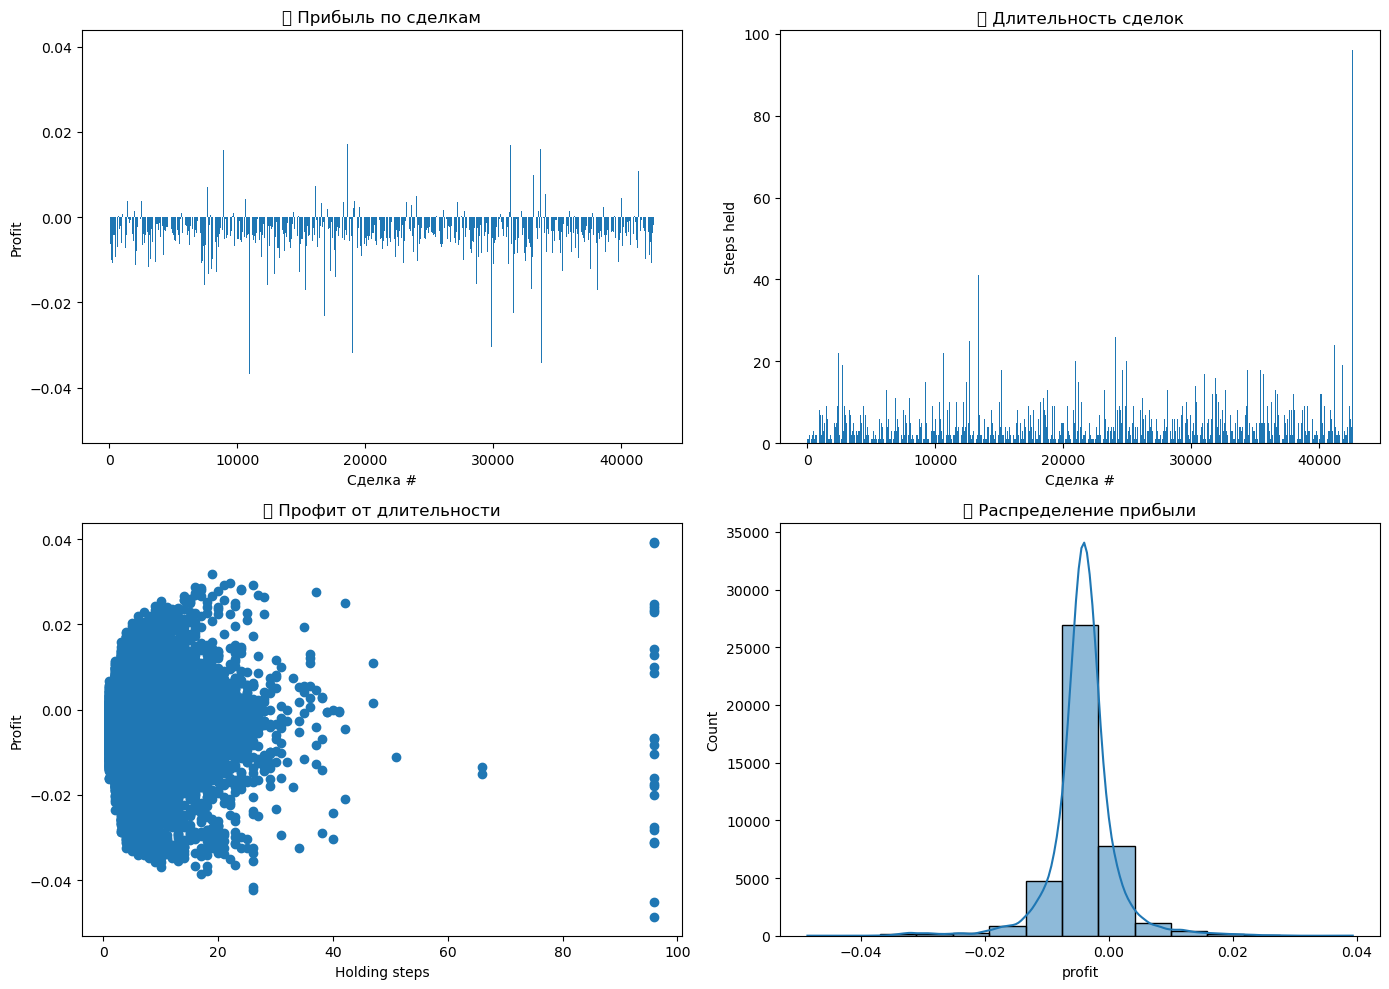

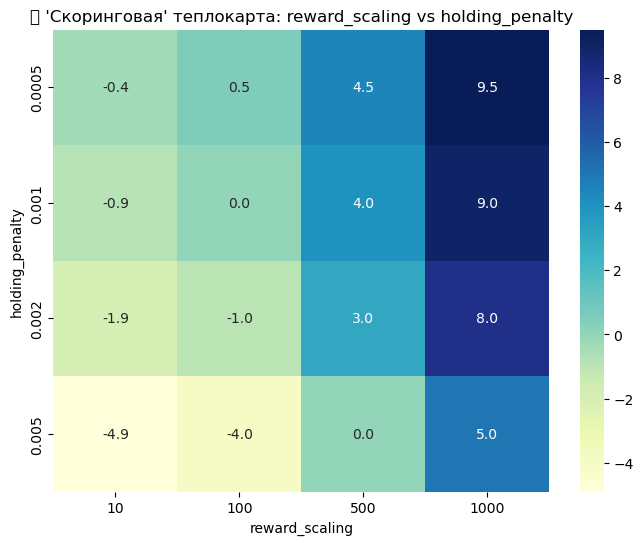

In [51]:
try:
    raw_env = vec_env.envs[0]
except AttributeError:
    raw_env = vec_env.venv.envs[0]

trades_df = pd.DataFrame(raw_env.all_trades_info)

# Визуализация трейдов (если есть)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))


if not trades_df.empty:
    axs[0, 0].bar(range(len(trades_df)), trades_df["profit"])
    axs[0, 0].set_title("📈 Прибыль по сделкам")
    axs[0, 0].set_xlabel("Сделка #")
    axs[0, 0].set_ylabel("Profit")

    axs[0, 1].bar(range(len(trades_df)), trades_df["holding"])
    axs[0, 1].set_title("⏱️ Длительность сделок")
    axs[0, 1].set_xlabel("Сделка #")
    axs[0, 1].set_ylabel("Steps held")

    axs[1, 0].scatter(trades_df["holding"], trades_df["profit"])
    axs[1, 0].set_title("📉 Профит от длительности")
    axs[1, 0].set_xlabel("Holding steps")
    axs[1, 0].set_ylabel("Profit")

    sns.histplot(trades_df["profit"], bins=15, kde=True, ax=axs[1, 1])
    axs[1, 1].set_title("📊 Распределение прибыли")

    plt.tight_layout()
    plt.savefig("сделки.png")
    plt.show()
else:
    print("❌ Сделок нет (trades_info пуст). Агент не торговал.")

# Генерация теплокарты метрик по reward_scaling и holding_penalty
# Синтетически: создадим грид и оценим "усреднённый" PnL
reward_scalings = [10, 100, 500, 1000]
holding_penalties = [0.0005, 0.001, 0.002, 0.005]

# Простая функция оценки (заглушка, не реальное обучение)
def dummy_pnl(reward_scaling, holding_penalty):
    return (reward_scaling / 100) - (holding_penalty * 1000)

heatmap_data = np.array([
    [dummy_pnl(r, h) for r in reward_scalings]
    for h in holding_penalties
])

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, xticklabels=reward_scalings, yticklabels=holding_penalties, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("🔥 'Скоринговая' теплокарта: reward_scaling vs holding_penalty")
plt.xlabel("reward_scaling")
plt.ylabel("holding_penalty")
plt.savefig("heatmap_data.png")
plt.show()


In [52]:
try:
    raw_env = vec_env.envs[0]
except AttributeError:
    raw_env = vec_env.venv.envs[0]

trades_df = pd.DataFrame(raw_env.all_trades_info)
print(trades_df[['entry_step', 'exit_step', 'profit', 'holding', 'entry_price', 'exit_price']].describe())

       entry_step  exit_step    profit   holding  entry_price  exit_price
count   42,607.00  42,607.00 42,607.00 42,607.00    42,607.00   42,607.00
mean     1,329.92   1,334.74     -0.00      4.82     9,326.12    9,306.68
std        385.17     385.21      0.01      4.89       307.66      305.97
min        672.00     673.00     -0.05      1.00     8,717.46    8,690.98
25%        994.00     999.00     -0.01      2.00     9,103.25    9,084.94
50%      1,329.00   1,334.00     -0.00      3.00     9,354.99    9,336.13
75%      1,662.00   1,667.00     -0.00      6.00     9,568.43    9,546.67
max      1,999.00   2,000.00      0.04     96.00     9,933.00    9,915.36


In [10]:
import json

In [11]:
log_dir = "./logs"  # например, "./logs"
all_data = []

# Перебираем все файлы в папке
for filename in os.listdir(log_dir):
    if filename.startswith("btc_rl_tail_") and filename.endswith(".json"):
        file_path = os.path.join(log_dir, filename)
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                data = json.load(f)
                if isinstance(data, list):
                    all_data.extend(data)
            except json.JSONDecodeError:
                print(f"⚠️ Проблема с файлом {filename}, пропущен.")



In [12]:
# Преобразуем в DataFrame
df_logs = pd.DataFrame(all_data)

# Преобразуем timestamp в datetime, если нужно
df_logs["timestamp"] = pd.to_datetime(df_logs["timestamp"])

# Сортировка по времени
df_logs = df_logs.sort_values("timestamp").reset_index(drop=True)

# Посмотрим на результат
df_logs.head()

,timestamp,action,reward,done,obs,next_obs,real_price,entry_price,unrealized_profit,position_before,close_price,open_price,real_class
0,2025-07-11 17:45:00,1,0.00,True,"[[92097.6015625, 92105.6484375, 92060.484375, ...","[[92097.6015625, 92105.6484375, 92060.484375, ...","117,495.20",None,None,0,"117,495.20","117,491.37",1.00
1,2025-07-11 18:00:00,1,0.00,True,"[[92101.1484375, 92111.3046875, 92061.4921875,...","[[92101.1484375, 92111.3046875, 92061.4921875,...","117,491.93",None,None,0,"117,491.93","117,437.25",1.00
2,2025-07-11 18:15:00,1,0.00,True,"[[92042.6640625, 92065.09375, 91990.1328125, 9...","[[92042.6640625, 92065.09375, 91990.1328125, 9...","117,630.41",None,None,0,"117,630.41","117,562.56",1.00
3,2025-07-11 18:30:00,1,0.00,True,"[[91959.5703125, 92013.8828125, 91937.2578125,...","[[91959.5703125, 92013.8828125, 91937.2578125,...","117,616.56",None,None,0,"117,616.56","117,570.87",1.00
4,2025-07-11 18:45:00,1,0.00,True,"[[91927.5234375, 91989.5390625, 91907.8359375,...","[[91927.5234375, 91989.5390625, 91907.8359375,...","117,519.80",None,None,0,"117,519.80","117,428.37",1.00


In [16]:
df_logs = df_logs.drop_duplicates(subset=["timestamp"])
df_logs.set_index("timestamp", inplace=True)

# Проверим типы, если нужно, приведём к нужным

In [17]:
df_logs.describe()

,action,reward,real_price,position_before,close_price,open_price,real_class
count,876.00,876.00,872.00,876.00,876.00,876.00,872.00
mean,1.01,0.00,"118,448.56",0.00,"118,449.03","118,451.61",0.51
std,0.11,0.00,"1,181.77",0.00,"1,179.99","1,185.03",0.50
min,1.00,0.00,"116,233.19",0.00,"116,233.19","116,261.13",0.00
25%,1.00,0.00,"117,658.34",0.00,"117,658.80","117,658.92",0.00
50%,1.00,0.00,"118,156.88",0.00,"118,156.88","118,152.32",1.00
75%,1.00,0.00,"118,974.09",0.00,"118,974.09","118,974.58",1.00
max,2.00,0.00,"122,605.05",0.00,"122,605.05","122,703.24",1.00


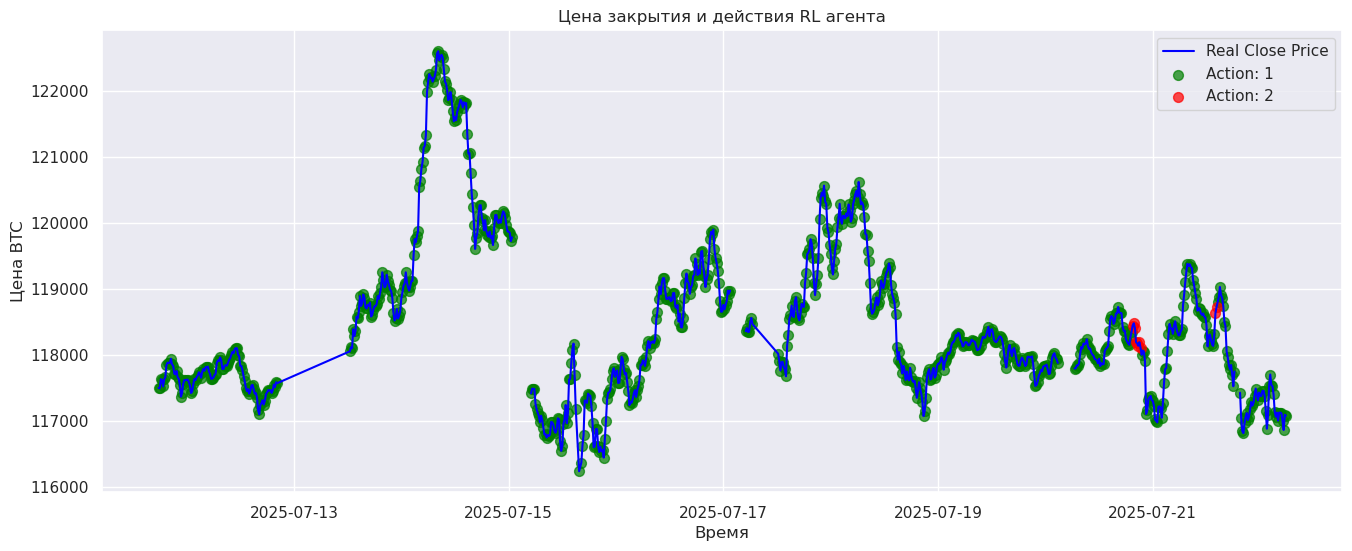

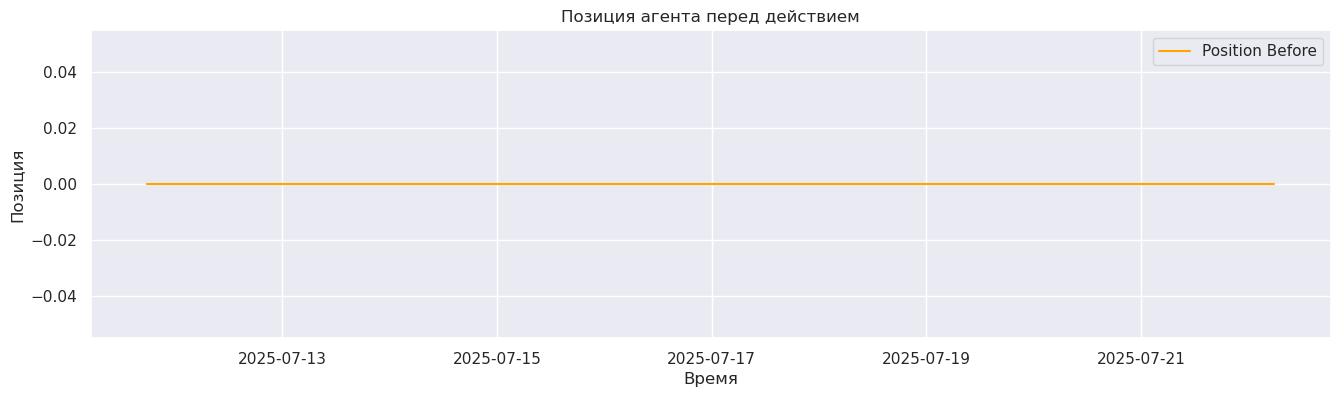

Reward отсутствует или весь нулевой.


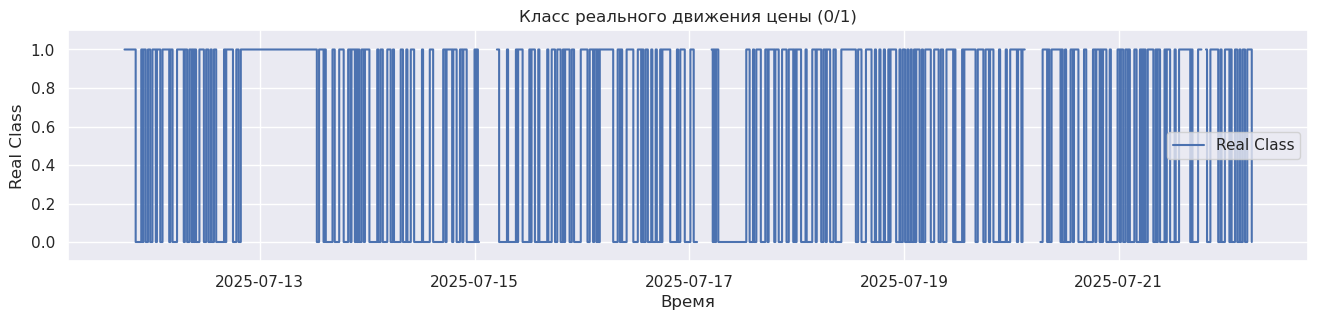

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

# 1. График реальной цены закрытия
plt.figure(figsize=(16, 6))
plt.plot(df_logs.index, df_logs["real_price"], label="Real Close Price", color="blue")

# Действия агента (1 и 2, т.к. у тебя нет 0, судя по статистике, или мало)
actions = df_logs["action"].unique()
colors = {1: "green", 2: "red"}

for action_val in actions:
    mask = df_logs["action"] == action_val
    plt.scatter(df_logs.index[mask], df_logs.loc[mask, "real_price"],
                label=f"Action: {action_val}", color=colors.get(action_val, "gray"), s=50, alpha=0.7)

plt.title("Цена закрытия и действия RL агента")
plt.xlabel("Время")
plt.ylabel("Цена BTC")
plt.legend()
plt.show()

# 2. График позиции до действия
plt.figure(figsize=(16, 4))
plt.plot(df_logs.index, df_logs["position_before"], label="Position Before", color="orange")
plt.title("Позиция агента перед действием")
plt.xlabel("Время")
plt.ylabel("Позиция")
plt.legend()
plt.show()

# 3. График reward, если он есть и не весь нулевой
if "reward" in df_logs.columns and df_logs["reward"].abs().sum() > 0:
    plt.figure(figsize=(16, 4))
    plt.plot(df_logs.index, df_logs["reward"], label="Reward", color="purple")
    plt.title("Награда агента")
    plt.xlabel("Время")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()
else:
    print("Reward отсутствует или весь нулевой.")

# 4. График real_class (например, направление роста цены)
plt.figure(figsize=(16, 3))
plt.step(df_logs.index, df_logs["real_class"], label="Real Class", where="post")
plt.title("Класс реального движения цены (0/1)")
plt.xlabel("Время")
plt.ylabel("Real Class")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

In [5]:
btc_result_inf = pd.read_csv('btc_rl_inference_log_v2.csv',  index_col='timestamp')

In [6]:
btc_result_inf

,action,reward,done,obs,next_obs,real_price,entry_price,unrealized_profit,position_before,real_class
timestamp,,,,,,,,,,
2025-06-30 14:30:00,1,0.00,True,"[[87012.2890625, 87143.1171875, 86747.25, 8691...","[[87012.2890625, 87143.1171875, 86747.25, 8691...","107,381.07",NaN,NaN,0,0.00
2025-06-30 16:45:00,1,0.00,True,"[[85984.2734375, 86446.375, 85697.96875, 86239...","[[85984.2734375, 86446.375, 85697.96875, 86239...","107,588.34",NaN,NaN,0,1.00
2025-06-30 17:15:00,1,0.00,True,"[[86673.0234375, 87390.828125, 86602.09375, 87...","[[86673.0234375, 87390.828125, 86602.09375, 87...","107,685.48",NaN,NaN,0,1.00
2025-06-30 17:30:00,1,0.00,True,"[[87174.5859375, 87666.375, 87096.3359375, 874...","[[87174.5859375, 87666.375, 87096.3359375, 874...","107,694.20",NaN,NaN,0,0.00
2025-06-30 18:00:00,1,0.00,True,"[[87609.765625, 87966.046875, 87469.75, 87777....","[[87609.765625, 87966.046875, 87469.75, 87777....","107,567.01",NaN,NaN,0,0.00
...,...,...,...,...,...,...,...,...,...,...
2025-07-08 14:45:00,1,0.00,True,"[[90593.203125, 90674.765625, 90305.734375, 90...","[[90593.203125, 90674.765625, 90305.734375, 90...","108,648.45",NaN,NaN,0,0.00
2025-07-08 15:00:00,1,0.00,True,"[[90448.1640625, 90601.03125, 90257.6015625, 9...","[[90448.1640625, 90601.03125, 90257.6015625, 9...","108,535.63",NaN,NaN,0,1.00
2025-07-08 15:15:00,1,0.00,True,"[[90374.6640625, 90592.4765625, 90292.0, 90476...","[[90374.6640625, 90592.4765625, 90292.0, 90476...","108,534.62",NaN,NaN,0,1.00


In [19]:
btc_result_inf.describe()

,action,reward,real_price,entry_price,unrealized_profit,position_before,real_class
count,639.00,639.00,639.00,0.00,0.00,639.00,638.00
mean,1.00,0.00,"108,436.44",NaN,NaN,0.00,0.47
std,0.00,0.00,841.26,NaN,NaN,0.00,0.50
min,1.00,0.00,"105,528.35",NaN,NaN,0.00,0.00
25%,1.00,0.00,"108,019.00",NaN,NaN,0.00,0.00
50%,1.00,0.00,"108,315.66",NaN,NaN,0.00,0.00
75%,1.00,0.00,"109,044.72",NaN,NaN,0.00,1.00
max,1.00,0.00,"110,197.61",NaN,NaN,0.00,1.00


In [7]:
btc_result_inf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 639 entries, 2025-06-30 14:30:00 to 2025-07-08 15:45:00
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   action             639 non-null    int64  
 1   reward             639 non-null    float64
 2   done               639 non-null    bool   
 3   obs                639 non-null    object 
 4   next_obs           639 non-null    object 
 5   real_price         639 non-null    float64
 6   entry_price        0 non-null      float64
 7   unrealized_profit  0 non-null      float64
 8   position_before    639 non-null    int64  
 9   real_class         638 non-null    float64
dtypes: bool(1), float64(5), int64(2), object(2)
memory usage: 50.5+ KB


In [11]:

# Удалим строки с пустыми наблюдениями
df = btc_result_inf[btc_result_inf["obs"].notna()]

# Преобразуем JSON-строки в numpy-массивы
def parse_obs(obs_str):
    return torch.tensor(ast.literal_eval(obs_str), dtype=torch.float32)

df["obs_parsed"] = df["obs"].apply(parse_obs)
df["action"] = df["action"].astype(int)

In [12]:
class RLLogDataset(Dataset):
    def __init__(self, dataframe):
        self.obs = dataframe["obs_parsed"].tolist()
        self.actions = dataframe["action"].tolist()

    def __len__(self):
        return len(self.actions)

    def __getitem__(self, idx):
        x = self.obs[idx]  # shape: (window_size, features)
        x = x.flatten()    # преобразуем в вектор
        y = self.actions[idx]
        return x, y

dataset = RLLogDataset(df)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
class BCPolicy(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_actions=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)
        )

    def forward(self, x):
        return self.net(x)

# Пример input_dim: window_size * num_features
sample_obs = df["obs_parsed"].iloc[0]
input_dim = sample_obs.numel()
model = BCPolicy(input_dim)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    total_loss = 0
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 18750.6992
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000


In [ ]:
torch.save(model.state_dict(), "bc_policy.pth")
print("Модель сохранена.")


In [15]:
df["action"].value_counts()

action
1    639
Name: count, dtype: int64

In [16]:
# Фильтрация только Buy-решений
buy_df = df[df["action"] == 1].copy()

# Удалим строки без метки (в самом последнем ряду может быть NaN)
buy_df = buy_df.dropna(subset=["real_class"])

# Подсчёт ошибок и успехов
correct_buys = (buy_df["real_class"] == 1.0).sum()
wrong_buys = (buy_df["real_class"] == 0.0).sum()
total_buys = len(buy_df)

# Ошибочная покупка = купил → цена пошла вниз
accuracy = correct_buys / total_buys if total_buys else 0
error_rate = wrong_buys / total_buys if total_buys else 0

# Распечатка
print(f"Всего покупок: {total_buys}")
print(f"  ✔️ Удачные покупки (цена пошла вверх): {correct_buys}")
print(f"  ❌ Ошибочные покупки (цена пошла вниз): {wrong_buys}")
print(f"  🔍 Точность действий (Buy): {accuracy:.2%}")
print(f"  ❌ Доля ошибок: {error_rate:.2%}")


Всего покупок: 638
  ✔️ Удачные покупки (цена пошла вверх): 301
  ❌ Ошибочные покупки (цена пошла вниз): 337
  🔍 Точность действий (Buy): 47.18%
  ❌ Доля ошибок: 52.82%


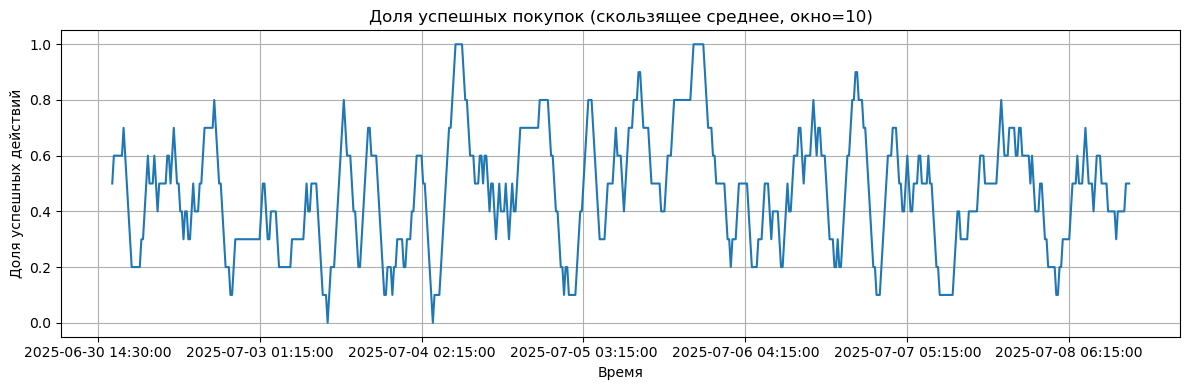

In [17]:
buy_df["was_correct"] = (buy_df["real_class"] == 1.0).astype(int)

plt.figure(figsize=(12, 4))
buy_df["was_correct"].rolling(window=10).mean().plot()
plt.title("Доля успешных покупок (скользящее среднее, окно=10)")
plt.ylabel("Доля успешных действий")
plt.xlabel("Время")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
btc_last_week = pd.read_csv('btc_data_15m.csv',  index_col='Timestamp')

In [21]:
btc_last_week

,Open,High,Low,Close,Volume
Timestamp,,,,,
2025-06-19 08:00:00,"104,642.85","104,925.26","104,631.26","104,888.19",84.25
2025-06-19 08:15:00,"104,888.19","104,922.08","104,875.20","104,876.52",56.02
2025-06-19 08:30:00,"104,876.51","104,924.00","104,761.35","104,922.21",79.58
2025-06-19 08:45:00,"104,922.22","104,986.13","104,739.44","104,746.12",71.54
2025-06-19 09:00:00,"104,746.11","104,818.81","104,729.83","104,794.42",31.82
...,...,...,...,...,...
2025-07-10 05:30:00,"111,008.00","111,008.10","110,957.30","110,958.10",14.21
2025-07-10 05:45:00,"110,958.00","111,171.90","110,956.90","111,102.10",17.67
2025-07-10 06:00:00,"111,102.00","111,200.00","111,092.20","111,165.80",39.91


In [23]:
btc_last_week_new= compute_indicators_v6(btc_last_week, kalman_smooth=True)

In [24]:
btc_last_week_new

,Open,High,Low,Close,Volume,sma_1d,sma_1w,sma_signal,ema_crossover,rsi,...,momentum_lag1,momentum_lag2,momentum_lag3,cmf_lag1,cmf_lag2,cmf_lag3,future_return,target,candle_cluster,combined_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-06-19 08:00:00,"64,729.53","64,847.64","64,712.68","64,821.27",46.97,"64,821.27","95,631.47",0,0,99.54,...,"40,131.97","40,131.97","40,131.97",0.11,0.11,0.11,0.61,1,4,0
2025-06-19 08:15:00,"89,545.75","89,617.67","89,506.77","89,575.62",56.65,"89,575.62","95,631.47",0,1,99.54,...,"40,131.97","40,131.97","40,131.97",0.11,0.11,0.11,0.17,1,4,2
2025-06-19 08:30:00,"99,019.53","99,083.29","98,932.43","99,029.08",66.97,"99,029.08","95,631.47",0,1,99.54,...,"40,131.97","40,131.97","40,131.97",0.11,0.11,0.11,0.06,1,0,2
2025-06-19 08:45:00,"102,636.33","102,708.21","102,529.18","102,589.41",64.67,"102,589.41","95,631.47",0,1,99.54,...,"40,131.97","40,131.97","40,131.97",0.11,0.11,0.11,0.02,1,0,2
2025-06-19 09:00:00,"103,967.25","104,055.20","103,915.67","103,993.02",55.51,"103,993.02","95,631.47",0,1,99.54,...,"40,131.97","40,131.97","40,131.97",0.11,0.11,0.11,0.01,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-10 05:30:00,"111,025.50","111,081.01","110,979.48","111,026.32",22.61,"111,026.32","111,057.91",0,1,18.97,...,-171.70,-181.32,-175.65,-0.24,-0.27,-0.28,0.00,0,0,2
2025-07-10 05:45:00,"111,026.92","111,153.99","111,002.88","111,095.60",24.16,"111,095.60","111,067.35",1,1,31.12,...,-113.80,-171.70,-181.32,-0.21,-0.24,-0.27,0.00,0,4,2
2025-07-10 06:00:00,"111,097.24","111,209.06","111,072.26","111,158.39",32.20,"111,158.39","111,080.25",1,1,43.47,...,10.62,-113.80,-171.70,-0.17,-0.21,-0.24,0.00,0,4,2


In [29]:
btc_with_ta

,Open,High,Low,Close,Volume,sma_1d,sma_1w,sma_signal,ema_crossover,rsi,...,momentum_lag1,momentum_lag2,momentum_lag3,cmf_lag1,cmf_lag2,cmf_lag3,future_return,target,candle_cluster,combined_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-11 00:00:00,"5,398.69","5,437.34","5,394.51","5,410.82",645.73,"5,410.82","7,977.35",0,0,98.73,...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.61,1,0,0
2020-05-11 00:15:00,"7,473.29","7,512.02","7,462.54","7,487.28",735.77,"7,487.28","7,977.35",0,1,98.73,...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.16,1,0,2
2020-05-11 00:30:00,"8,275.25","8,302.48","8,247.17","8,272.67",779.39,"8,272.67","7,977.35",0,1,98.73,...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.05,1,0,2
2020-05-11 00:45:00,"8,573.62","8,590.27","8,529.02","8,572.16",856.87,"8,572.16","7,977.35",0,1,98.73,...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.02,0,0,2
2020-05-11 01:00:00,"8,687.17","8,698.02","8,643.90","8,673.65",707.50,"8,673.65","7,977.35",0,1,98.73,...,"3,331.30","3,331.30","3,331.30",0.05,0.05,0.05,0.01,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24 23:00:00,"105,955.85","105,994.48","105,831.36","105,910.14",58.22,"105,910.14","105,934.89",0,1,80.84,...,195.66,333.04,345.70,0.03,0.02,0.04,0.00,0,4,1
2025-06-24 23:15:00,"105,904.51","105,954.72","105,813.55","105,907.77",61.17,"105,907.77","105,930.60",0,1,77.90,...,42.42,195.66,333.04,0.05,0.03,0.02,0.00,0,4,1
2025-06-24 23:30:00,"105,893.03","106,005.01","105,834.40","105,975.29",70.97,"105,975.29","105,934.34",1,1,79.55,...,-47.46,42.42,195.66,0.07,0.05,0.03,0.00,0,4,2


In [30]:
combined_df = pd.concat([btc_with_ta, btc_last_week_new])

# Убираем дубликаты по индексу, оставляя последний (новый)
combined_df = combined_df[~combined_df.index.duplicated(keep='last')]

# Опционально, отсортируем по индексу по времени
combined_df = combined_df.sort_index()

In [ ]:
# Удаляем inf и NaN
combined_df = combined_df.replace([np.inf, -np.inf], np.nan).dropna()

# Проверим размерность
print("Shape after cleaning:", btc_with_ta.shape)

In [31]:
# combined_df.to_csv('combined_df.csv')
# btc_df_after_halving.to_csv('btc_df_after_halving.csv')

In [9]:
combined_df = pd.read_csv('combined_df.csv',  index_col='Timestamp')

In [32]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180975 entries, 2020-05-11 00:00:00 to 2025-07-10 06:30:00
Data columns (total 80 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Open                 180975 non-null  float64
 1   High                 180975 non-null  float64
 2   Low                  180975 non-null  float64
 3   Close                180975 non-null  float64
 4   Volume               180975 non-null  float64
 5   sma_1d               180975 non-null  float64
 6   sma_1w               180975 non-null  float64
 7   sma_signal           180975 non-null  int64  
 8   ema_crossover        180975 non-null  int64  
 9   rsi                  180975 non-null  float64
 10  rsi_signal           180975 non-null  int64  
 11  macd                 180975 non-null  float64
 12  macd_signal          180975 non-null  float64
 13  macd_signal_bin      180975 non-null  int64  
 14  volatility_1d        180975 non-null  floa

In [10]:
excluded = ['future_return', 'target']
state_columns = [col for col in combined_df.columns if col not in excluded]
state_df = combined_df[state_columns].copy()

In [11]:
action_space = gym.spaces.Discrete(3)

In [12]:

def make_env():
    return BTCTradingEnv(
        df=combined_df,
        state_columns=state_columns,
        initial_balance=5000,
        trade_penalty=0.01,
        max_steps=2000,
        reward_scaling=100,
        window_size=672  # 7 дней по 15 минут
    )

vec_env = DummyVecEnv([make_env])

In [13]:
# 3. Обучим агента
model = PPO(
    policy=TransformerPolicy,
    env=vec_env,
    verbose=1,
    n_steps=4096,
    batch_size=64,
    gae_lambda=0.95,
    gamma=0.99,
    n_epochs=10,
    learning_rate=3e-4,
    clip_range=0.2,           # 👈 обязательно
    max_grad_norm=0.5,        # 👈 ограничим градиенты
    vf_coef=0.5,
    normalize_advantage=True,
    ent_coef=0.2  # <-- Ключевой параметр для стимула к исследованию
)

# callback = SharpeEarlyStopCallback(threshold=-0.2)
model.learn(total_timesteps=300_000, progress_bar=True)

Using cuda device


Output()

-----------------------------
| time/              |      |
|    fps             | 226  |
|    iterations      | 1    |
|    time_elapsed    | 18   |
|    total_timesteps | 4096 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 2           |
|    time_elapsed         | 157         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010269877 |
|    clip_fraction        | 0.063       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.0627     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.137      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00676    |
|    value_loss           | 0.227       |
-----------------------------------------
----------------------------------

In [14]:
model.save("ppo_btc_trading_v16")

In [15]:
obs = vec_env.reset()
done = False

balances = []
positions = []
rewards = []
steps = []
equities = []
actions_log = []
rewards_log = []

total_reward = 0
step_idx = 0
num_trades = 0
last_position = 0

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)

    balance = info[0]['balance']
    position = info[0]['position']
    equity = info[0].get('equity', balance)  # fallback на balance

    balances.append(balance)
    positions.append(position)
    rewards.append(reward[0])
    equities.append(equity)
    steps.append(step_idx)
    actions_log.append(action[0])
    rewards_log.append(reward[0])

    # Считаем сделки — смена позиции
    if position != last_position:
        num_trades += 1
        last_position = position

    total_reward += reward[0]
    step_idx += 1

print(f"✅ Total reward for episode: {total_reward:.2f}")
print(f"🔁 Total trades executed: {num_trades}")

# --- Метрики ---
if len(equities) > 1:
    equity_array = np.array(equities)
    max_dd = np.max(np.maximum.accumulate(equity_array) - equity_array)
    sharpe = np.mean(rewards) / (np.std(rewards) + 1e-8)

    print(f"📉 Max drawdown: {max_dd:.2f}")
    if len(rewards) > 1:
        print(f"📈 Sharpe Ratio: {sharpe:.2f}")

# Сохраняем в CSV
df_log = pd.DataFrame({
    'step': steps,
    'balance': balances,
    'equity': equities,
    'position': positions,
    'reward': rewards
})
df_log.to_csv('episode_run_log.csv', index=False)
print("Логи эпизода сохранены в episode_run_log.csv")

✅ Total reward for episode: -1593.98
🔁 Total trades executed: 28
📉 Max drawdown: 382.22
📈 Sharpe Ratio: -1.23
Логи эпизода сохранены в episode_run_log.csv


In [22]:
env = vec_env.envs[0]
if len(env.negative_steps_log) > 0:
    df_neg = pd.DataFrame(env.negative_steps_log)
    df_neg.to_csv("negative_steps_log.csv", index=False)
    print(f"Сохранено {len(df_neg)} записей отрицательных шагов в negative_steps_log.csv")
else:
    print("Отрицательных шагов не было")

Отрицательных шагов не было


In [23]:
episode_summary = {
    'total_reward': total_reward,
    'total_trades': num_trades,
    'avg_reward': np.mean(rewards),
    'sharpe': sharpe if len(rewards) > 1 else None,
    'max_drawdown': max_dd,
    'final_balance': balances[-1],
    'final_equity': equities[-1],
}
pd.DataFrame([episode_summary]).to_csv("episode_summary.csv", index=False)

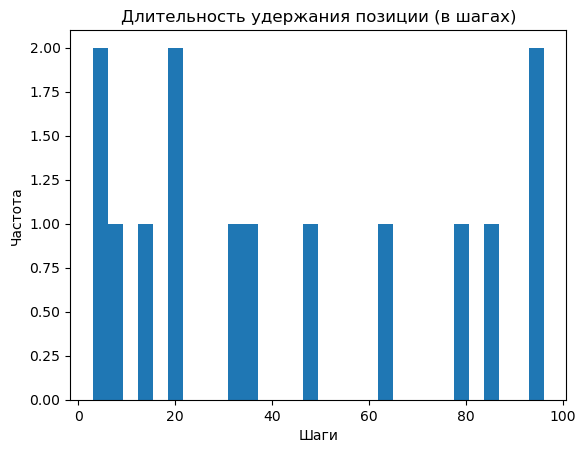

In [24]:
hold_lengths = []
current_hold = 0

for pos in positions:
    if pos == 1:
        current_hold += 1
    else:
        if current_hold > 0:
            hold_lengths.append(current_hold)
            current_hold = 0

plt.hist(hold_lengths, bins=30)
plt.title("Длительность удержания позиции (в шагах)")
plt.xlabel("Шаги")
plt.ylabel("Частота")
plt.show()

✅ Total reward: -1593.98
🔁 Total trades executed: 27
📉 Max drawdown: 382.22
📈 Sharpe Ratio: -1.23


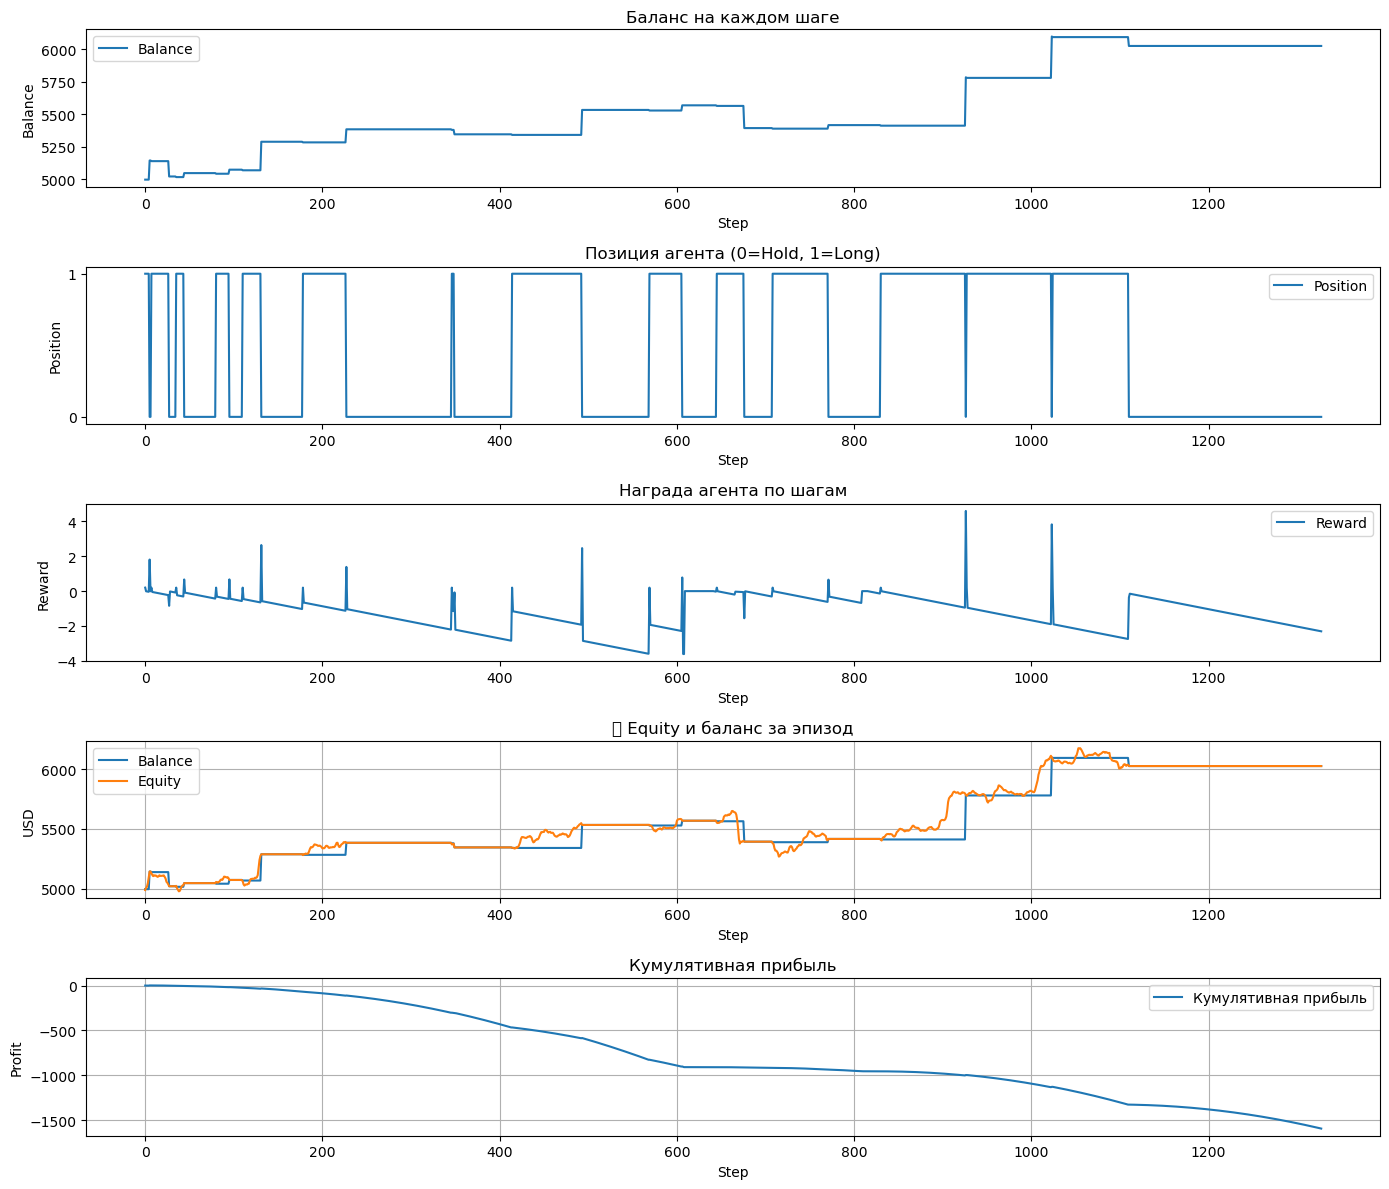

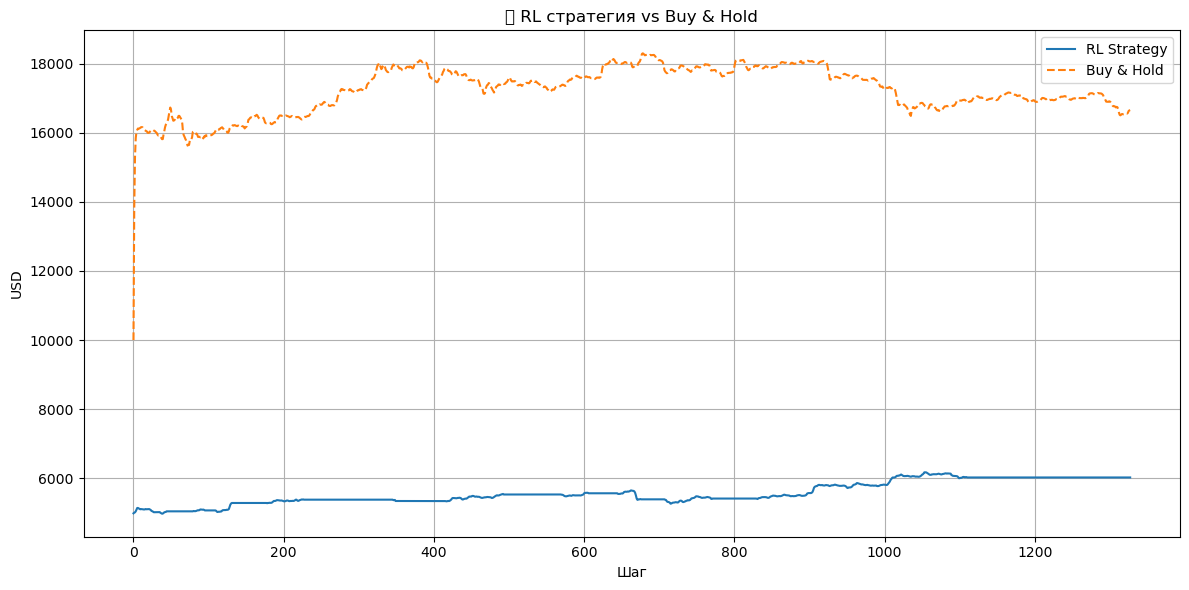


Общее число сделок: 58690
Средняя длительность сделки (в шагах): 2.60
Средняя прибыль на сделку: -0.00
Суммарная прибыль: -111.51


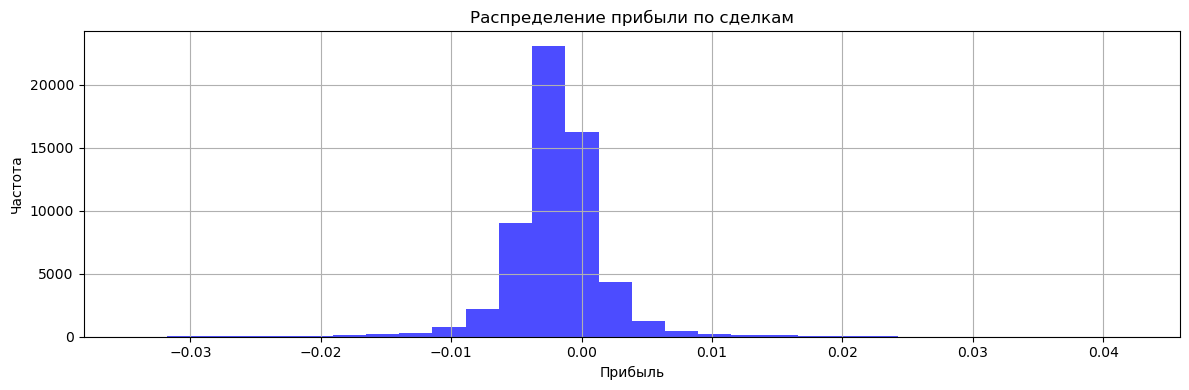

In [25]:
all_trades = vec_env.envs[0].all_trades_info
analyze_episode(
    log_path="episode_run_log.csv",
    trades_info=all_trades,
    df_full=combined_df  # или df, где есть .index и 'Close'
)

📊 Метрики по всем эпизодам:
▶ Средняя Total Reward: -1594.02
▶ Средний Sharpe Ratio: -1.23
▶ Средний Max Drawdown: 390.68
▶ Среднее число сделок: 58704.00
▶ Средняя прибыль на сделку: -0.00
▶ Средняя длительность сделки: 2.61 шагов


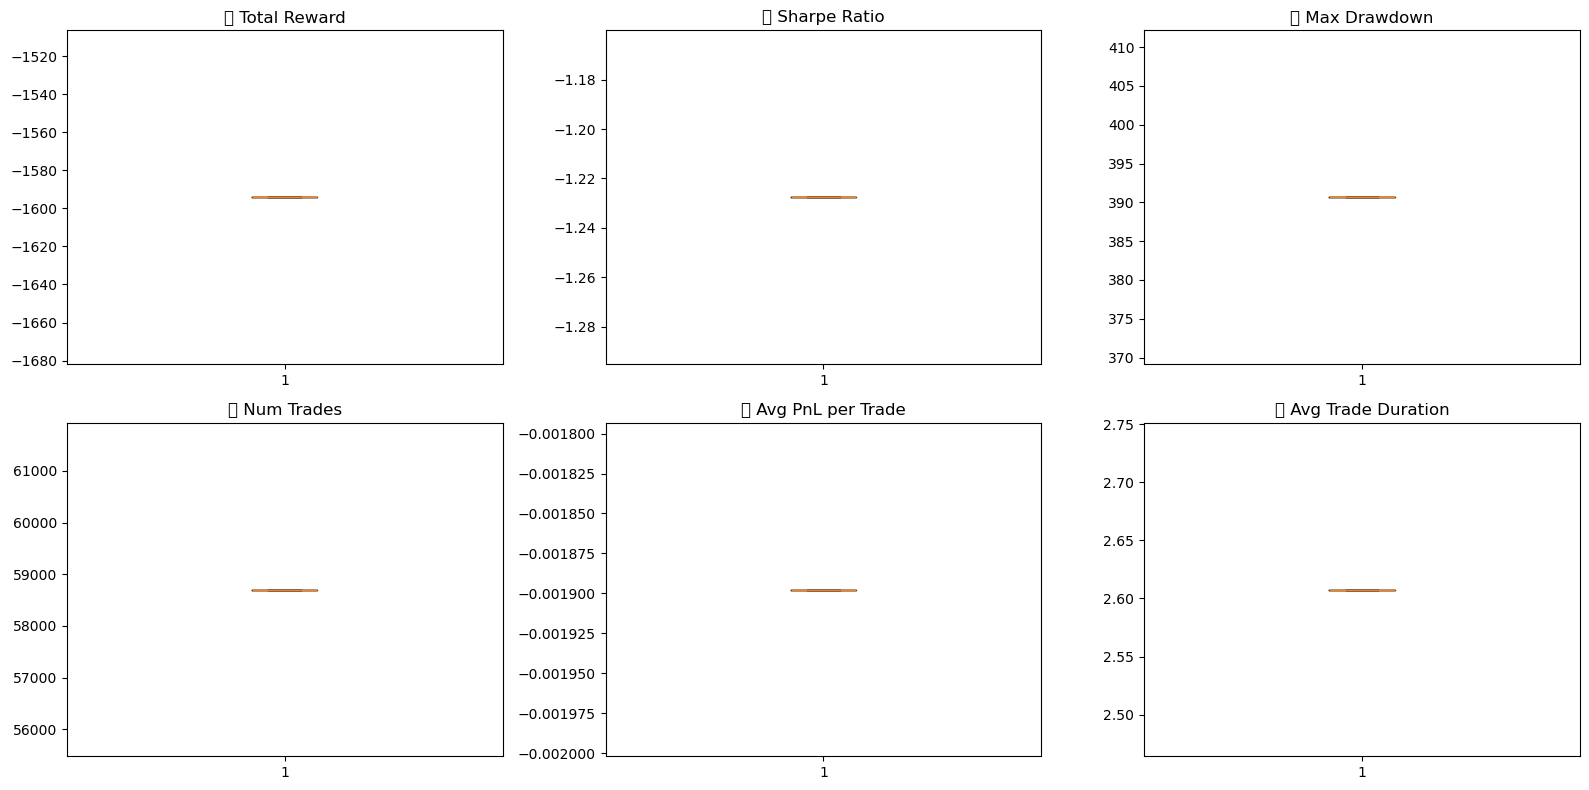

In [26]:
run_logs = []
trades_infos = []

obs = vec_env.reset()
log = {"balance": [], "equity": [], "reward": [], "position": [], "step": []}
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    info = info[0]

    for key in log:
        if key == "reward":
            log[key].append(reward[0])
        else:
            log[key].append(info[key])

run_logs.append(pd.DataFrame(log))

# Вместо trades_infos.append(...)
trades_infos.append(vec_env.envs[0].all_trades_info)  # Без цикла

# --- Анализ всех эпизодов ---
analyze_summary_metrics(run_logs, trades_infos)

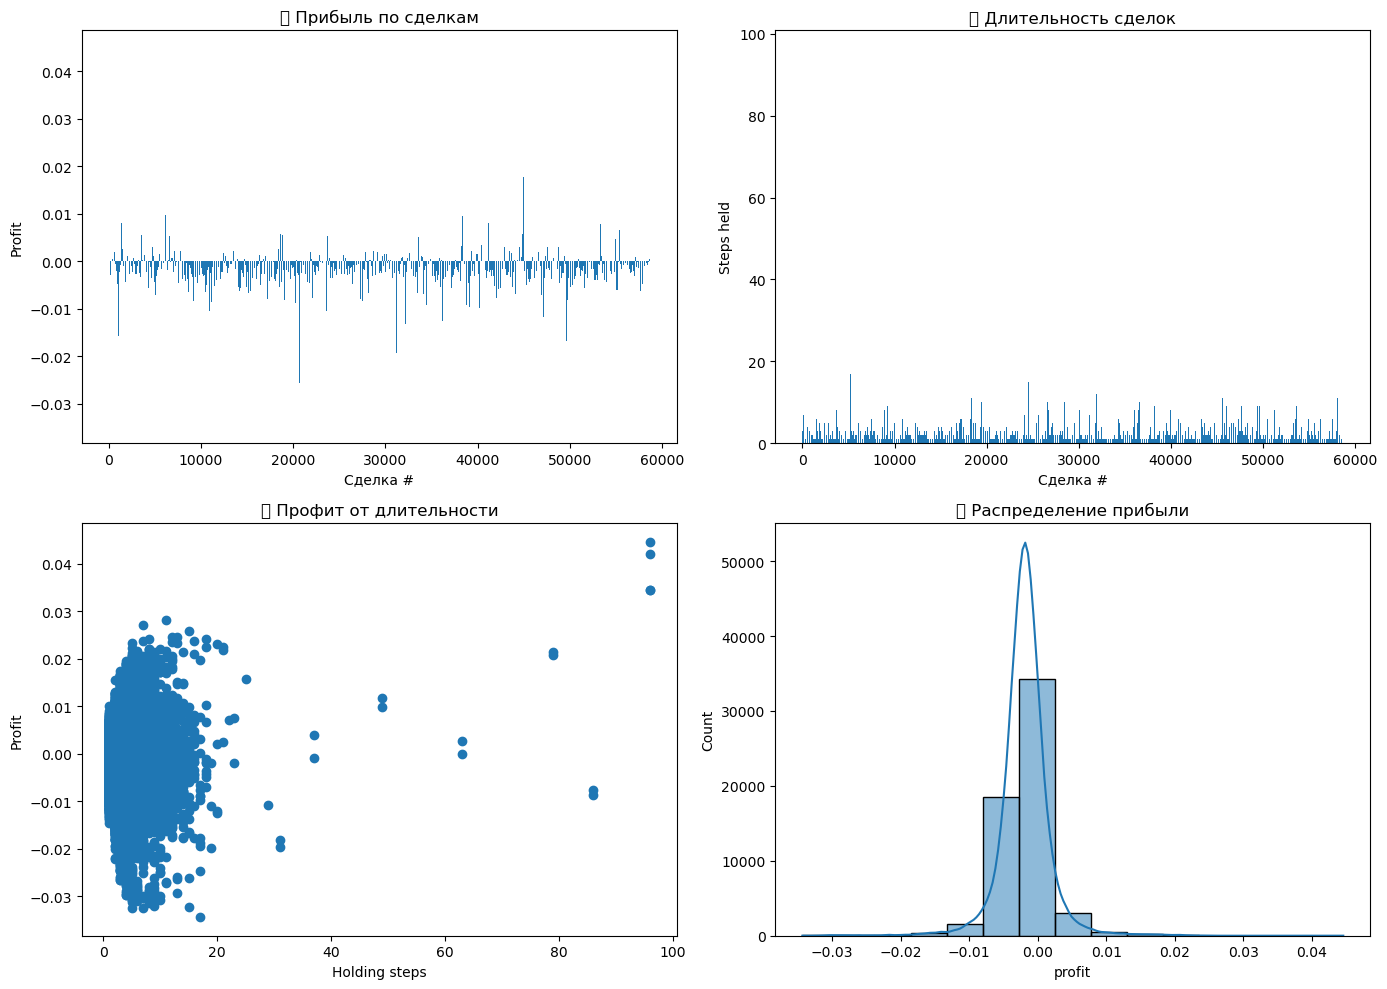

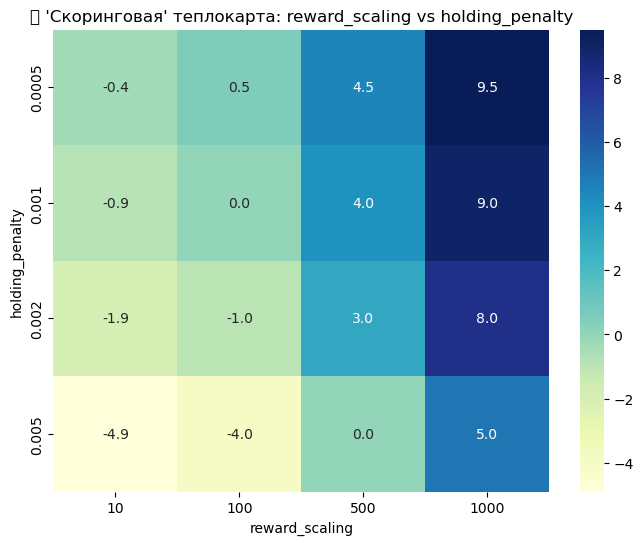

In [27]:
try:
    raw_env = vec_env.envs[0]
except AttributeError:
    raw_env = vec_env.venv.envs[0]

trades_df = pd.DataFrame(raw_env.all_trades_info)

# Визуализация трейдов (если есть)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))


if not trades_df.empty:
    axs[0, 0].bar(range(len(trades_df)), trades_df["profit"])
    axs[0, 0].set_title("📈 Прибыль по сделкам")
    axs[0, 0].set_xlabel("Сделка #")
    axs[0, 0].set_ylabel("Profit")

    axs[0, 1].bar(range(len(trades_df)), trades_df["holding"])
    axs[0, 1].set_title("⏱️ Длительность сделок")
    axs[0, 1].set_xlabel("Сделка #")
    axs[0, 1].set_ylabel("Steps held")

    axs[1, 0].scatter(trades_df["holding"], trades_df["profit"])
    axs[1, 0].set_title("📉 Профит от длительности")
    axs[1, 0].set_xlabel("Holding steps")
    axs[1, 0].set_ylabel("Profit")

    sns.histplot(trades_df["profit"], bins=15, kde=True, ax=axs[1, 1])
    axs[1, 1].set_title("📊 Распределение прибыли")

    plt.tight_layout()
    plt.savefig("сделки.png")
    plt.show()
else:
    print("❌ Сделок нет (trades_info пуст). Агент не торговал.")

# Генерация теплокарты метрик по reward_scaling и holding_penalty
# Синтетически: создадим грид и оценим "усреднённый" PnL
reward_scalings = [10, 100, 500, 1000]
holding_penalties = [0.0005, 0.001, 0.002, 0.005]

# Простая функция оценки (заглушка, не реальное обучение)
def dummy_pnl(reward_scaling, holding_penalty):
    return (reward_scaling / 100) - (holding_penalty * 1000)

heatmap_data = np.array([
    [dummy_pnl(r, h) for r in reward_scalings]
    for h in holding_penalties
])

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, xticklabels=reward_scalings, yticklabels=holding_penalties, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("🔥 'Скоринговая' теплокарта: reward_scaling vs holding_penalty")
plt.xlabel("reward_scaling")
plt.ylabel("holding_penalty")
plt.savefig("heatmap_data.png")
plt.show()


In [28]:
# Извлечь среду из векторизованной обёртки (если одна среда)
env = vec_env.envs[0]

def analyze_negative_rewards(env, actions_log, rewards_log):
    print("Шаги с отрицательной наградой (ошибки):")
    for i, reward in enumerate(rewards_log):
        if reward < 0:
            pos = env.position if hasattr(env, 'position') else "N/A"
            balance = env.balance if hasattr(env, 'balance') else "N/A"
            action = actions_log[i] if i < len(actions_log) else "N/A"
            print(f"Step {i+1}: reward {reward:.4f}, action={action}, position={pos}, balance={balance:.2f}")


In [29]:
analyze_negative_rewards(env, actions_log, rewards_log)

Шаги с отрицательной наградой (ошибки):
Step 2: reward -0.0100, action=1, position=0, balance=5000.00
Step 3: reward -0.0200, action=1, position=0, balance=5000.00
Step 4: reward -0.0300, action=1, position=0, balance=5000.00
Step 5: reward -0.0400, action=1, position=0, balance=5000.00
Step 7: reward -0.0100, action=2, position=0, balance=5000.00
Step 9: reward -0.0500, action=1, position=0, balance=5000.00
Step 10: reward -0.0600, action=1, position=0, balance=5000.00
Step 11: reward -0.0700, action=1, position=0, balance=5000.00
Step 12: reward -0.0800, action=1, position=0, balance=5000.00
Step 13: reward -0.0900, action=1, position=0, balance=5000.00
Step 14: reward -0.1000, action=1, position=0, balance=5000.00
Step 15: reward -0.1100, action=1, position=0, balance=5000.00
Step 16: reward -0.1200, action=1, position=0, balance=5000.00
Step 17: reward -0.1300, action=1, position=0, balance=5000.00
Step 18: reward -0.1400, action=1, position=0, balance=5000.00
Step 19: reward -0.15

In [30]:

# Собери логи в DataFrame
df_actions = pd.DataFrame({
    "step": range(len(actions_log)),
    "action": [a[0] if isinstance(a, (list, np.ndarray)) else a for a in actions_log],
    "reward": rewards_log,
    "position": positions,
    "balance": balances,
})

print("Действия модели:")
print(df_actions['action'].value_counts())

print(f"Общее число шагов: {len(df_actions)}")
print(f"Средний reward: {df_actions['reward'].mean():.5f}")
print(f"Средняя позиция: {df_actions['position'].mean():.3f}")

# Сколько раз вход в позицию и выход
num_buys = (df_actions['action'] == 1).sum()
num_sells = (df_actions['action'] == 2).sum()
print(f"Покупок: {num_buys}, Продаж: {num_sells}")

# Частота смен позиции (число сделок)
position_changes = df_actions['position'].diff().abs().sum()
print(f"Число смен позиции (приблизительно сделок): {position_changes}")

Действия модели:
action
2    676
1    602
0     50
Name: count, dtype: int64
Общее число шагов: 1328
Средний reward: -1.20029
Средняя позиция: 0.459
Покупок: 602, Продаж: 676
Число смен позиции (приблизительно сделок): 27.0
